## Problem Statement

Predict customer actions to keep them with the company. Analyze relevant customer data and create targeted plans to keep customers engaged.

**Content**:

- Customers who have recently left – referred to as "Churn" in the column
- Services each customer has subscribed to – like phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account details – duration of their subscription, contract specifics, payment method, usage of paperless billing, monthly expenses, and total expenses
- Customer demographics – gender, age group, and whether they have partners and dependents
- Churn – a dependent feature (Customers labeled 'Yes' have left, while 'No' indicates they have stayed)

## 1. Importing the libraries and data

In [1]:
# Libraries for data analysis
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
%matplotlib inline

# Libraries for feature selection
from sklearn.feature_selection import SelectKBest, chi2

# Libraries used during modeling
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import GridSearchCV, train_test_split

# Libraries for machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Artificial Neural Network libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Libraries for model evaluation
from sklearn.metrics import (
    classification_report, roc_curve, log_loss, auc,
    precision_score, recall_score, f1_score, roc_auc_score,
    accuracy_score, confusion_matrix, precision_recall_fscore_support
)

# Custom Libraries for model evaluation and visualization
from Utilities.EvaluationMetrics import *
from Utilities.Visualizations import *
from Utilities.TransformFeatures import *

# Library used to save our model
import pickle

In [2]:
curr_dir=os.getcwd()
rel_file_path='Data\\Telco-Customer-Churn.csv'
full_file_path = os.path.join(curr_dir, rel_file_path)
original_df = pd.read_csv(full_file_path)

## 2. Data Exploration

In [3]:
original_df.shape

(7043, 21)

In [4]:
original_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


- None of the columns have any null values.
- Only Monthly Charges, Senior Citizen and tenure columns have numeric data type. Rest of the columns have string values.
- TotalCharges column has numeric values but in string format. 

In [6]:
# Total charges are in object dtype so convert into Numerical feature 
original_df['TotalCharges'] = pd.to_numeric(original_df['TotalCharges'], errors='coerce')

In [7]:
# Checking statistics of numerical features
original_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
# Checking statistics of categorical features
original_df.describe(include=['object'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [9]:
original_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
# Target variable
target='Churn'

# Categorical features
cf=['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 
    'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
    'Contract', 'PaperlessBilling','PaymentMethod']

# Numerical features
nf=['tenure', 'MonthlyCharges', 'TotalCharges']

print(f"The dataset has {len(cf)} categorical features and {len(nf)} numerical features.")

The dataset has 16 categorical features and 3 numerical features.


## 3. Exploratory Data Analysis

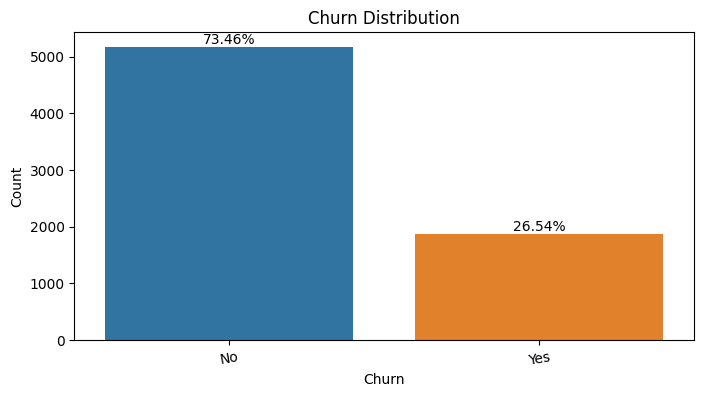

In [11]:
# Calculate the percentage distribution of the target variable
count_plot(original_df, target)

**Inference:**

- The dataset appears to be imbalanced, with approximately 73.46% of the samples related to no customer churn.

In [12]:
#Checking number of unique rows in each feature
original_df[cf].nunique().sort_values()

gender              2
SeniorCitizen       2
Partner             2
Dependents          2
PhoneService        2
PaperlessBilling    2
MultipleLines       3
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
StreamingTV         3
StreamingMovies     3
Contract            3
PaymentMethod       4
dtype: int64

                               Visualising Categorical Features:                                


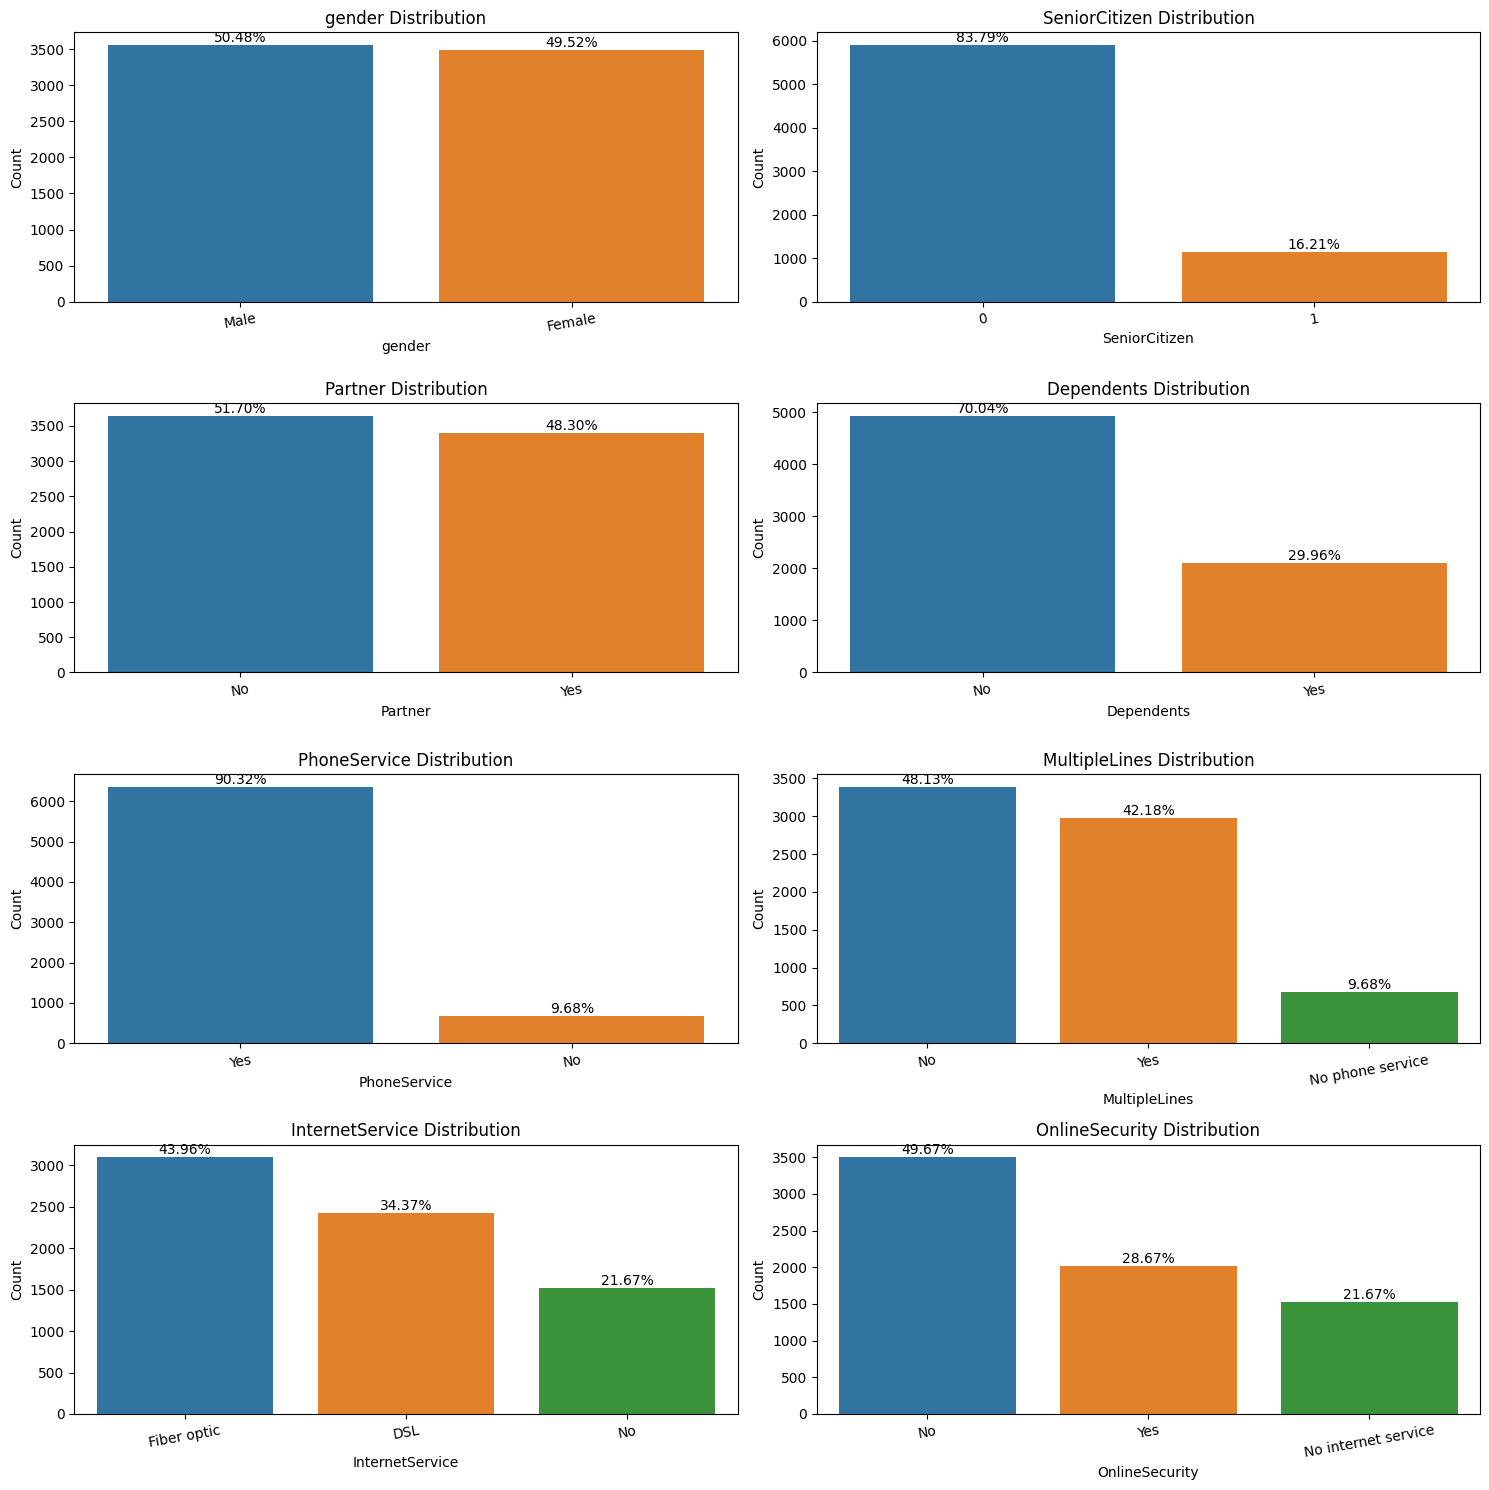

In [14]:
#Visualising the categorical features 
print('\033[1mVisualising Categorical Features:'.center(100))
plt.figure(figsize=[15,15])

for i, col_name in enumerate(cf[:8]):
    plt.subplot(4,2,i+1)
    
    # Create the count plot with percentages as labels        
    count_order = original_df[col_name].value_counts().index
    ax = sns.countplot(data=original_df, x=col_name, order=count_order)
    plt.title(col_name + ' Distribution')
    plt.ylabel('Count')
    
    # Add percentage labels to the bars using target_percentage
    target_percentage = (original_df[col_name].value_counts()/original_df[col_name].count()) * 100
    for p, percentage in zip(ax.patches, target_percentage):
        ax.annotate(f"{percentage:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.xticks(rotation=10)

plt.tight_layout()
plt.show()

**Inference:**

- The number of male and female customers is about the same. Additionally, the count of customers with and without partners is equal.
- There are very few senior citizen customers, and the number of customers with dependents is also quite low.
- A high percentage of customers, around 90%, use phone services.

                               Visualising Categorical Features:                                


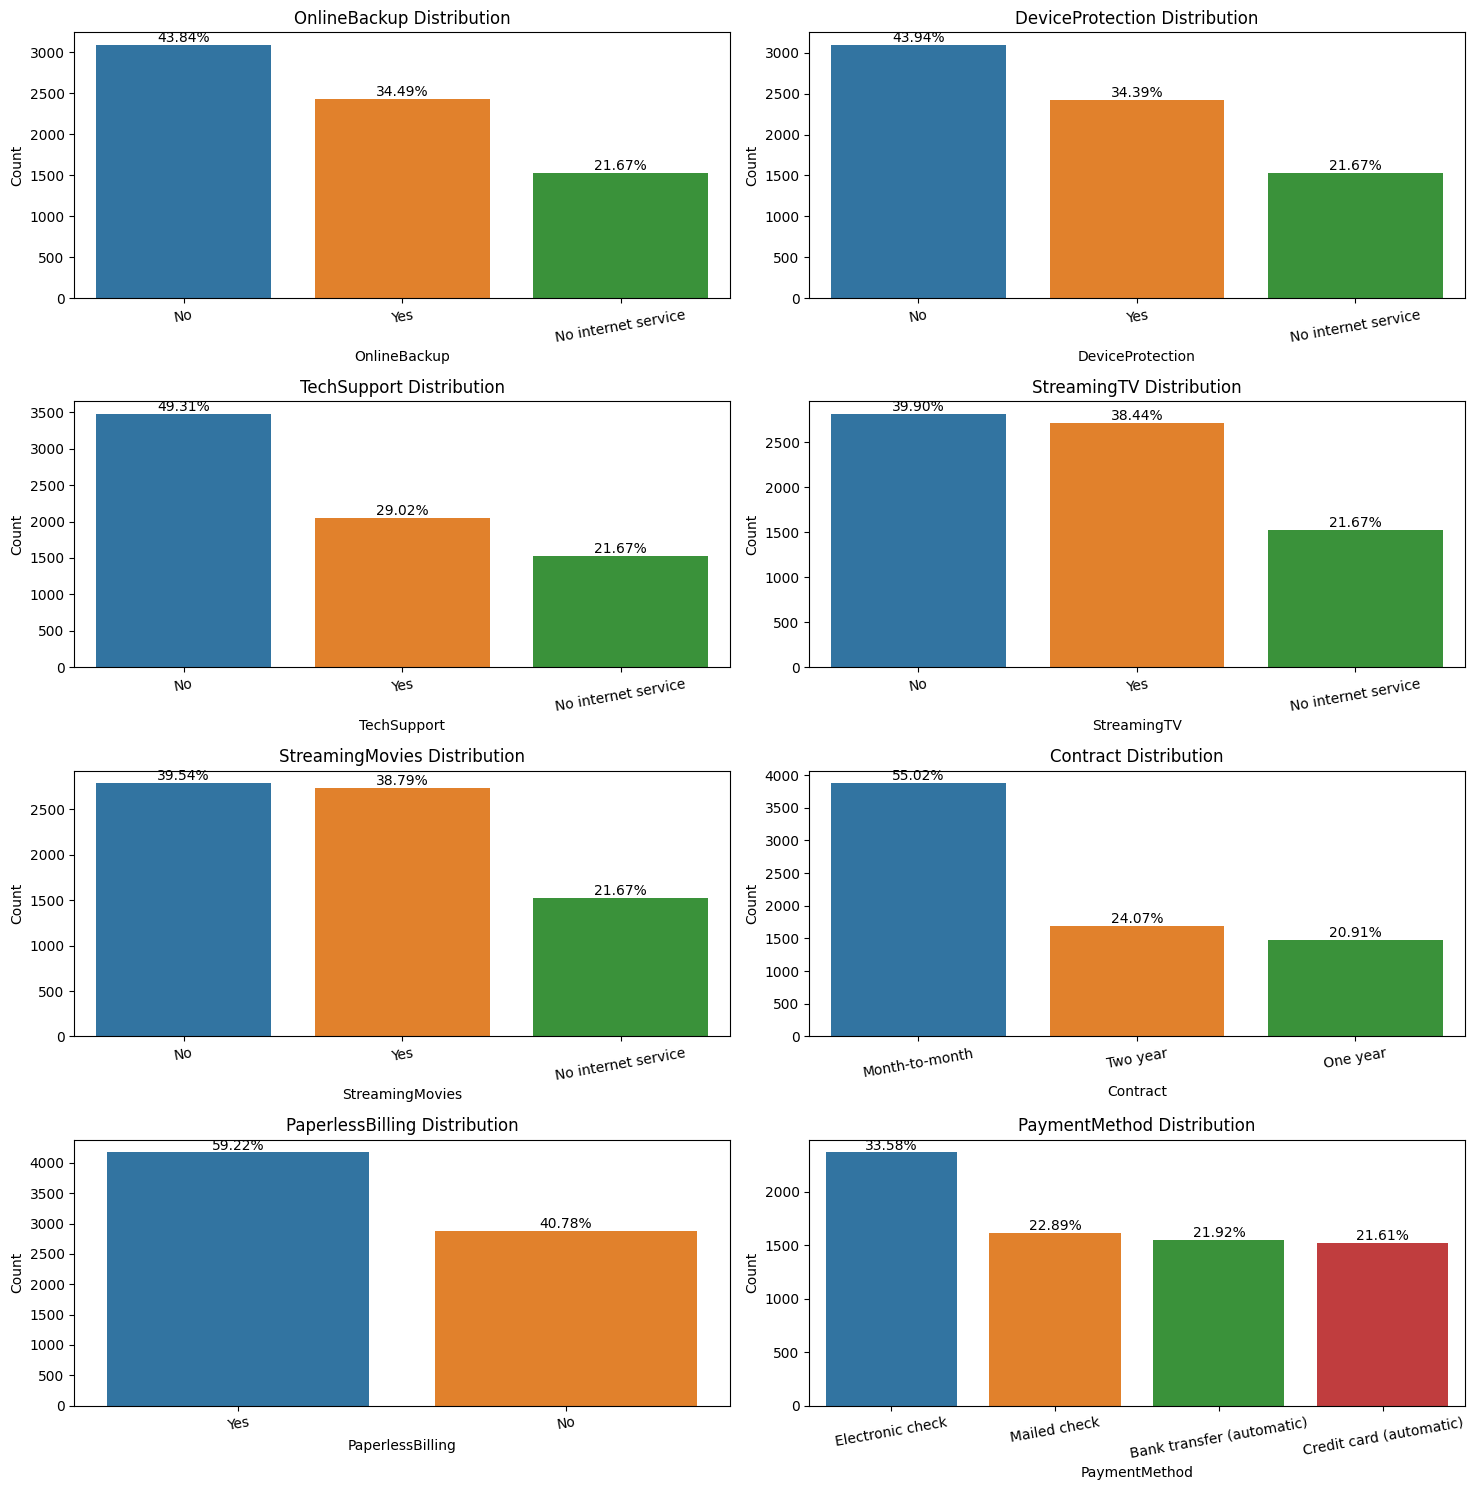

In [15]:
#Visualising the categorical features 
print('\033[1mVisualising Categorical Features:'.center(100))
plt.figure(figsize=[15,15])

for i, col_name in enumerate(cf[8:]):
    plt.subplot(4,2,i+1)
    
    # Create the count plot with percentages as labels        
    count_order = original_df[col_name].value_counts().index
    ax = sns.countplot(data=original_df, x=col_name, order=count_order)
    plt.title(col_name + ' Distribution')
    plt.ylabel('Count')
    
    # Add percentage labels to the bars using target_percentage
    target_percentage = (original_df[col_name].value_counts()/original_df[col_name].count()) * 100
    for p, percentage in zip(ax.patches, target_percentage):
        ax.annotate(f"{percentage:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.xticks(rotation=10)

plt.tight_layout()
plt.show()

**Inference:**

- About half of all customers don't use technical support.
- Nearly 44% don't use online backup or device protection.
- Over 50% of customers prefer month-to-month contracts and opt for paperless billing.
- The most common payment method is electronic check.

In [20]:
nf

['tenure', 'MonthlyCharges', 'TotalCharges']

                                                Numeric Features Distribution                                                 


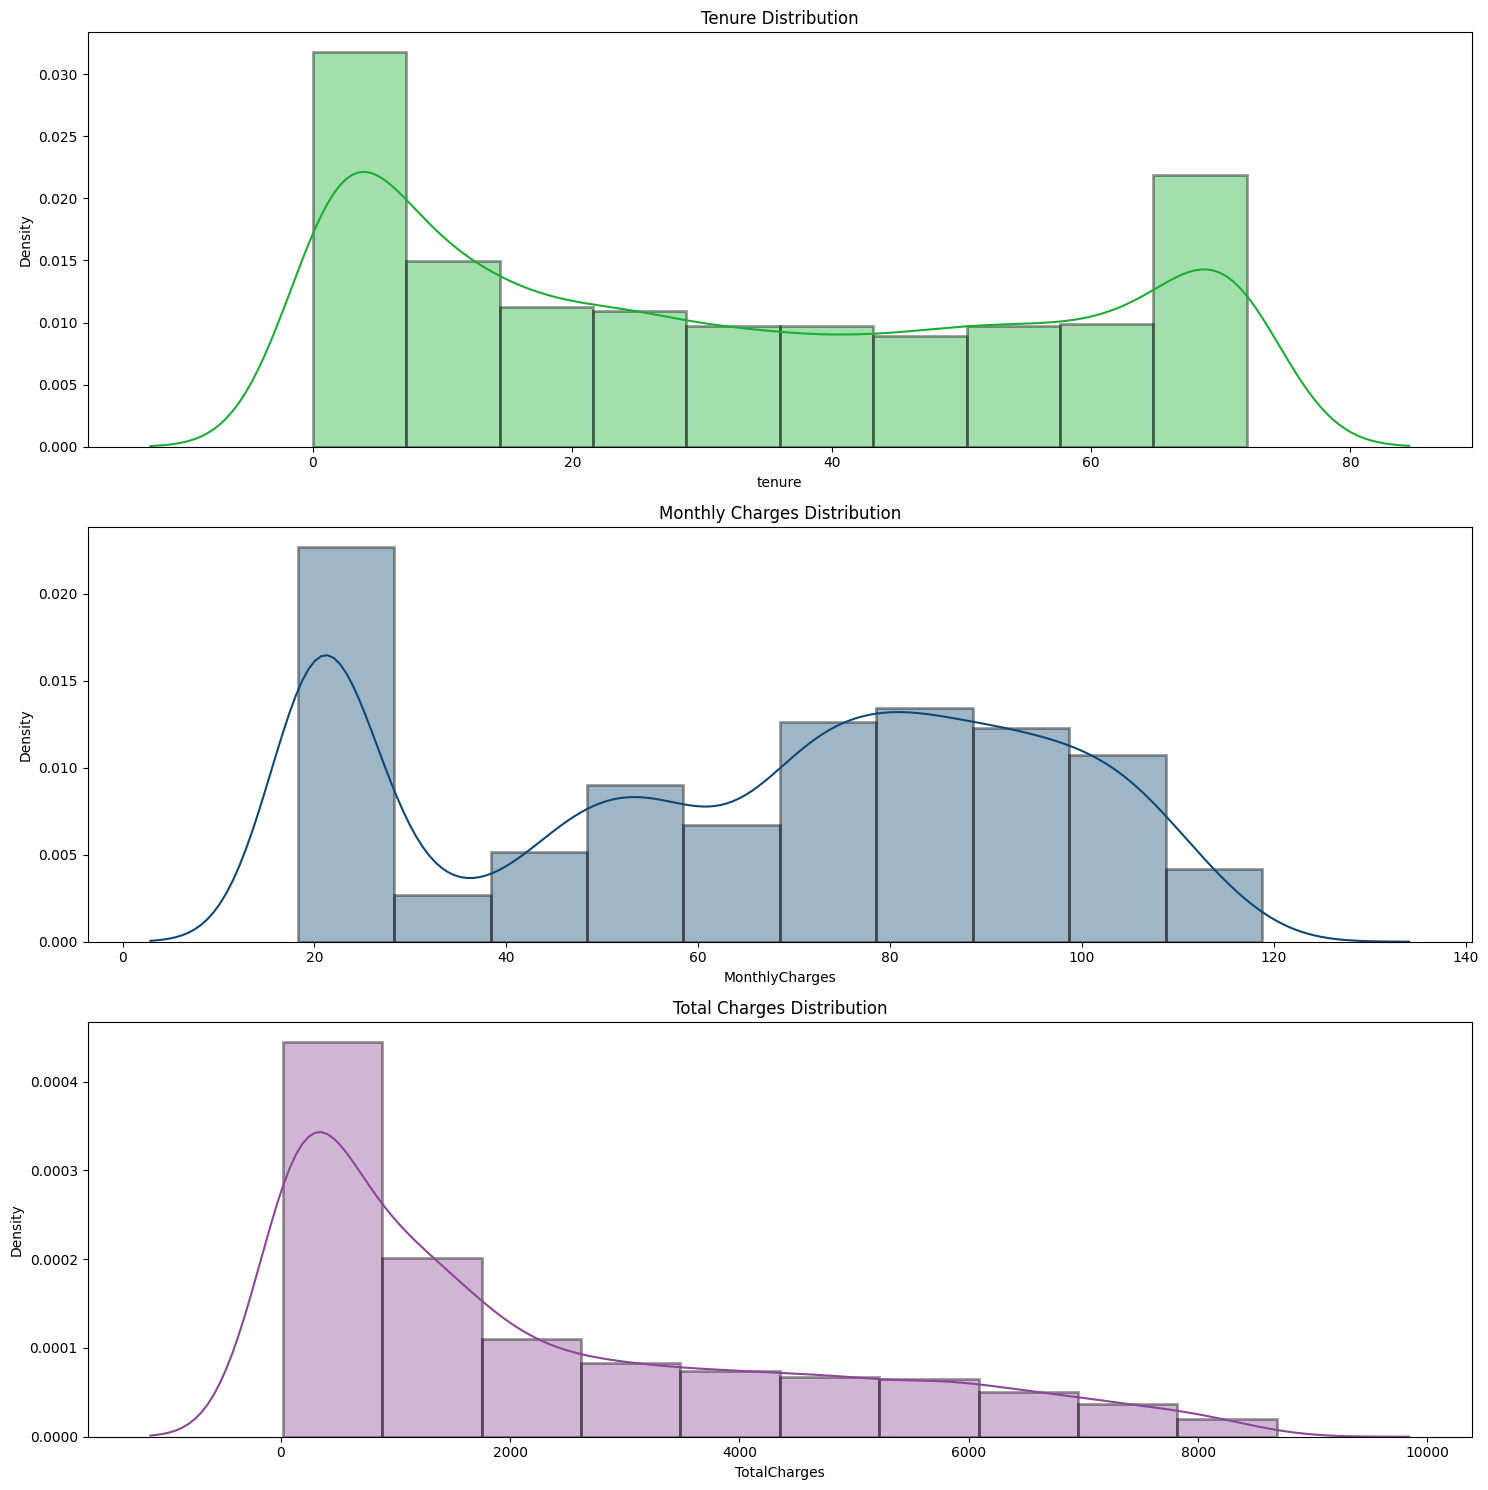

In [27]:
#Visualising the numeric features 
print('\033[1mNumeric Features Distribution'.center(130))

plt.figure(figsize=[15,15])

plt.subplot(3,1,1)
sns.distplot(original_df['tenure'],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, 
                 color=list(np.random.randint([255,255,255])/255))
plt.title('Tenure Distribution')

plt.subplot(3,1,2)
sns.distplot(original_df['MonthlyCharges'],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, 
                 color=list(np.random.randint([255,255,255])/255))
plt.title('Monthly Charges Distribution')

plt.subplot(3,1,3)
sns.distplot(original_df['TotalCharges'],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, 
                 color=list(np.random.randint([255,255,255])/255))
plt.title('Total Charges Distribution')

plt.tight_layout()
plt.show()

**Inference:**

- Tenure and monthly charges data seem to be binormally distributed.
- Total charges seem to have a skewed distribution.

### Target variable vs Input Feature

#### Target variable vs Input Categorical Feature

                            Categorical features count w.r.t target:                            


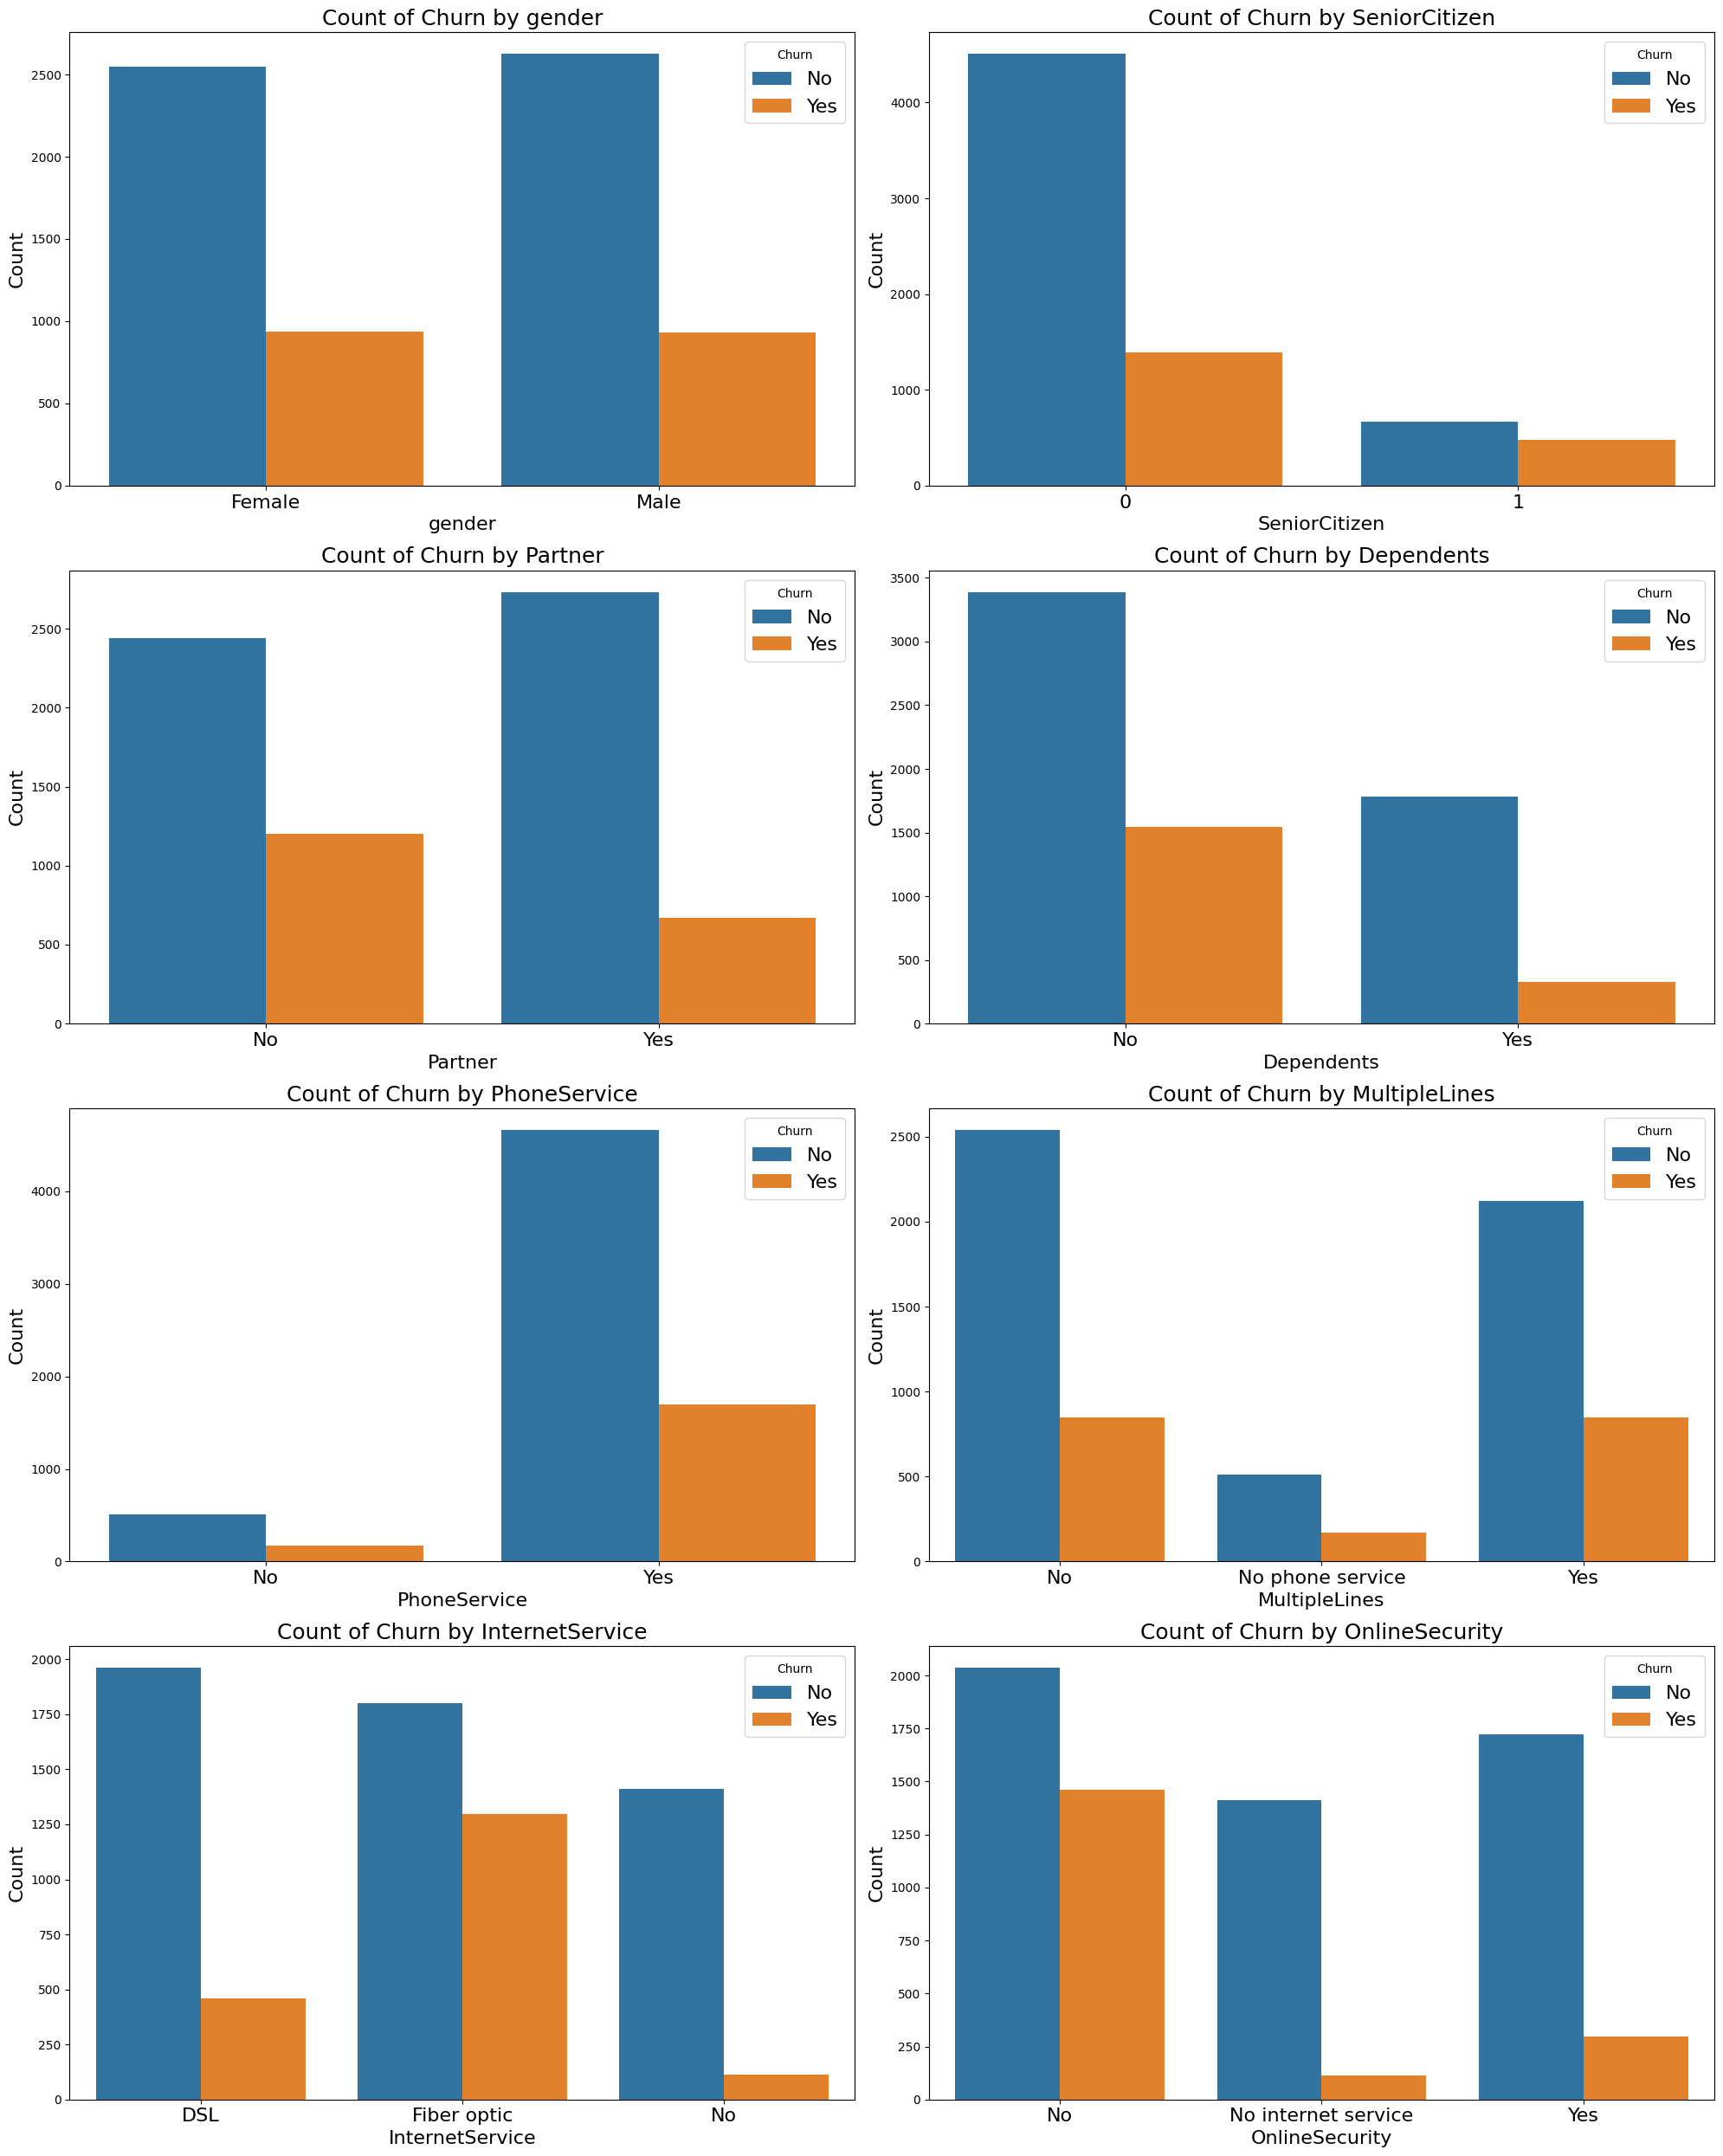

In [44]:
#Visualising the categorical features 
print('\033[1mCategorical features count w.r.t target:'.center(100))
plt.figure(figsize=[20,25])
y_name=target

for i, col_name in enumerate(cf[:8]):
    plt.subplot(4,2,i+1)
    
    # Count the occurrences of each combination of categories
    x_name = col_name
    count_df = original_df.groupby([y_name, x_name]).size().reset_index(name='Count')
    sns.barplot(x=x_name, y='Count', hue=y_name, data=count_df)
    
    plot_title = 'Count of ' + y_name + ' by ' + x_name
    plt.title(plot_title, fontsize=18)
    plt.xlabel(x_name, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.legend(title=y_name, fontsize=16)        
    plt.xticks(rotation=0, fontsize=16)

plt.tight_layout()
plt.show()

**Inference:**

- Customer churn rates are quite similar for both male and female customers. Additionally, the number of SeniorCitizen customers is relatively low. Among them, approximately 40% experienced churn.

- Customers who live with a partner tend to have lower churn compared to those who don't. Similarly, customers without dependents also exhibit a higher churn rate.

- Surprisingly, in the case of PhoneService, more customers were retained even among those without the service, compared to those who canceled it.

- For customers with MultipleLines, the churn rate remains consistent regardless of whether multiple lines are present or not.

- Customers who opted for fiber optic service showed a higher churn rate than those who chose DSL.

- Interestingly, customers who subscribed to online security services tended to churn less.

                            Categorical features count w.r.t target:                            


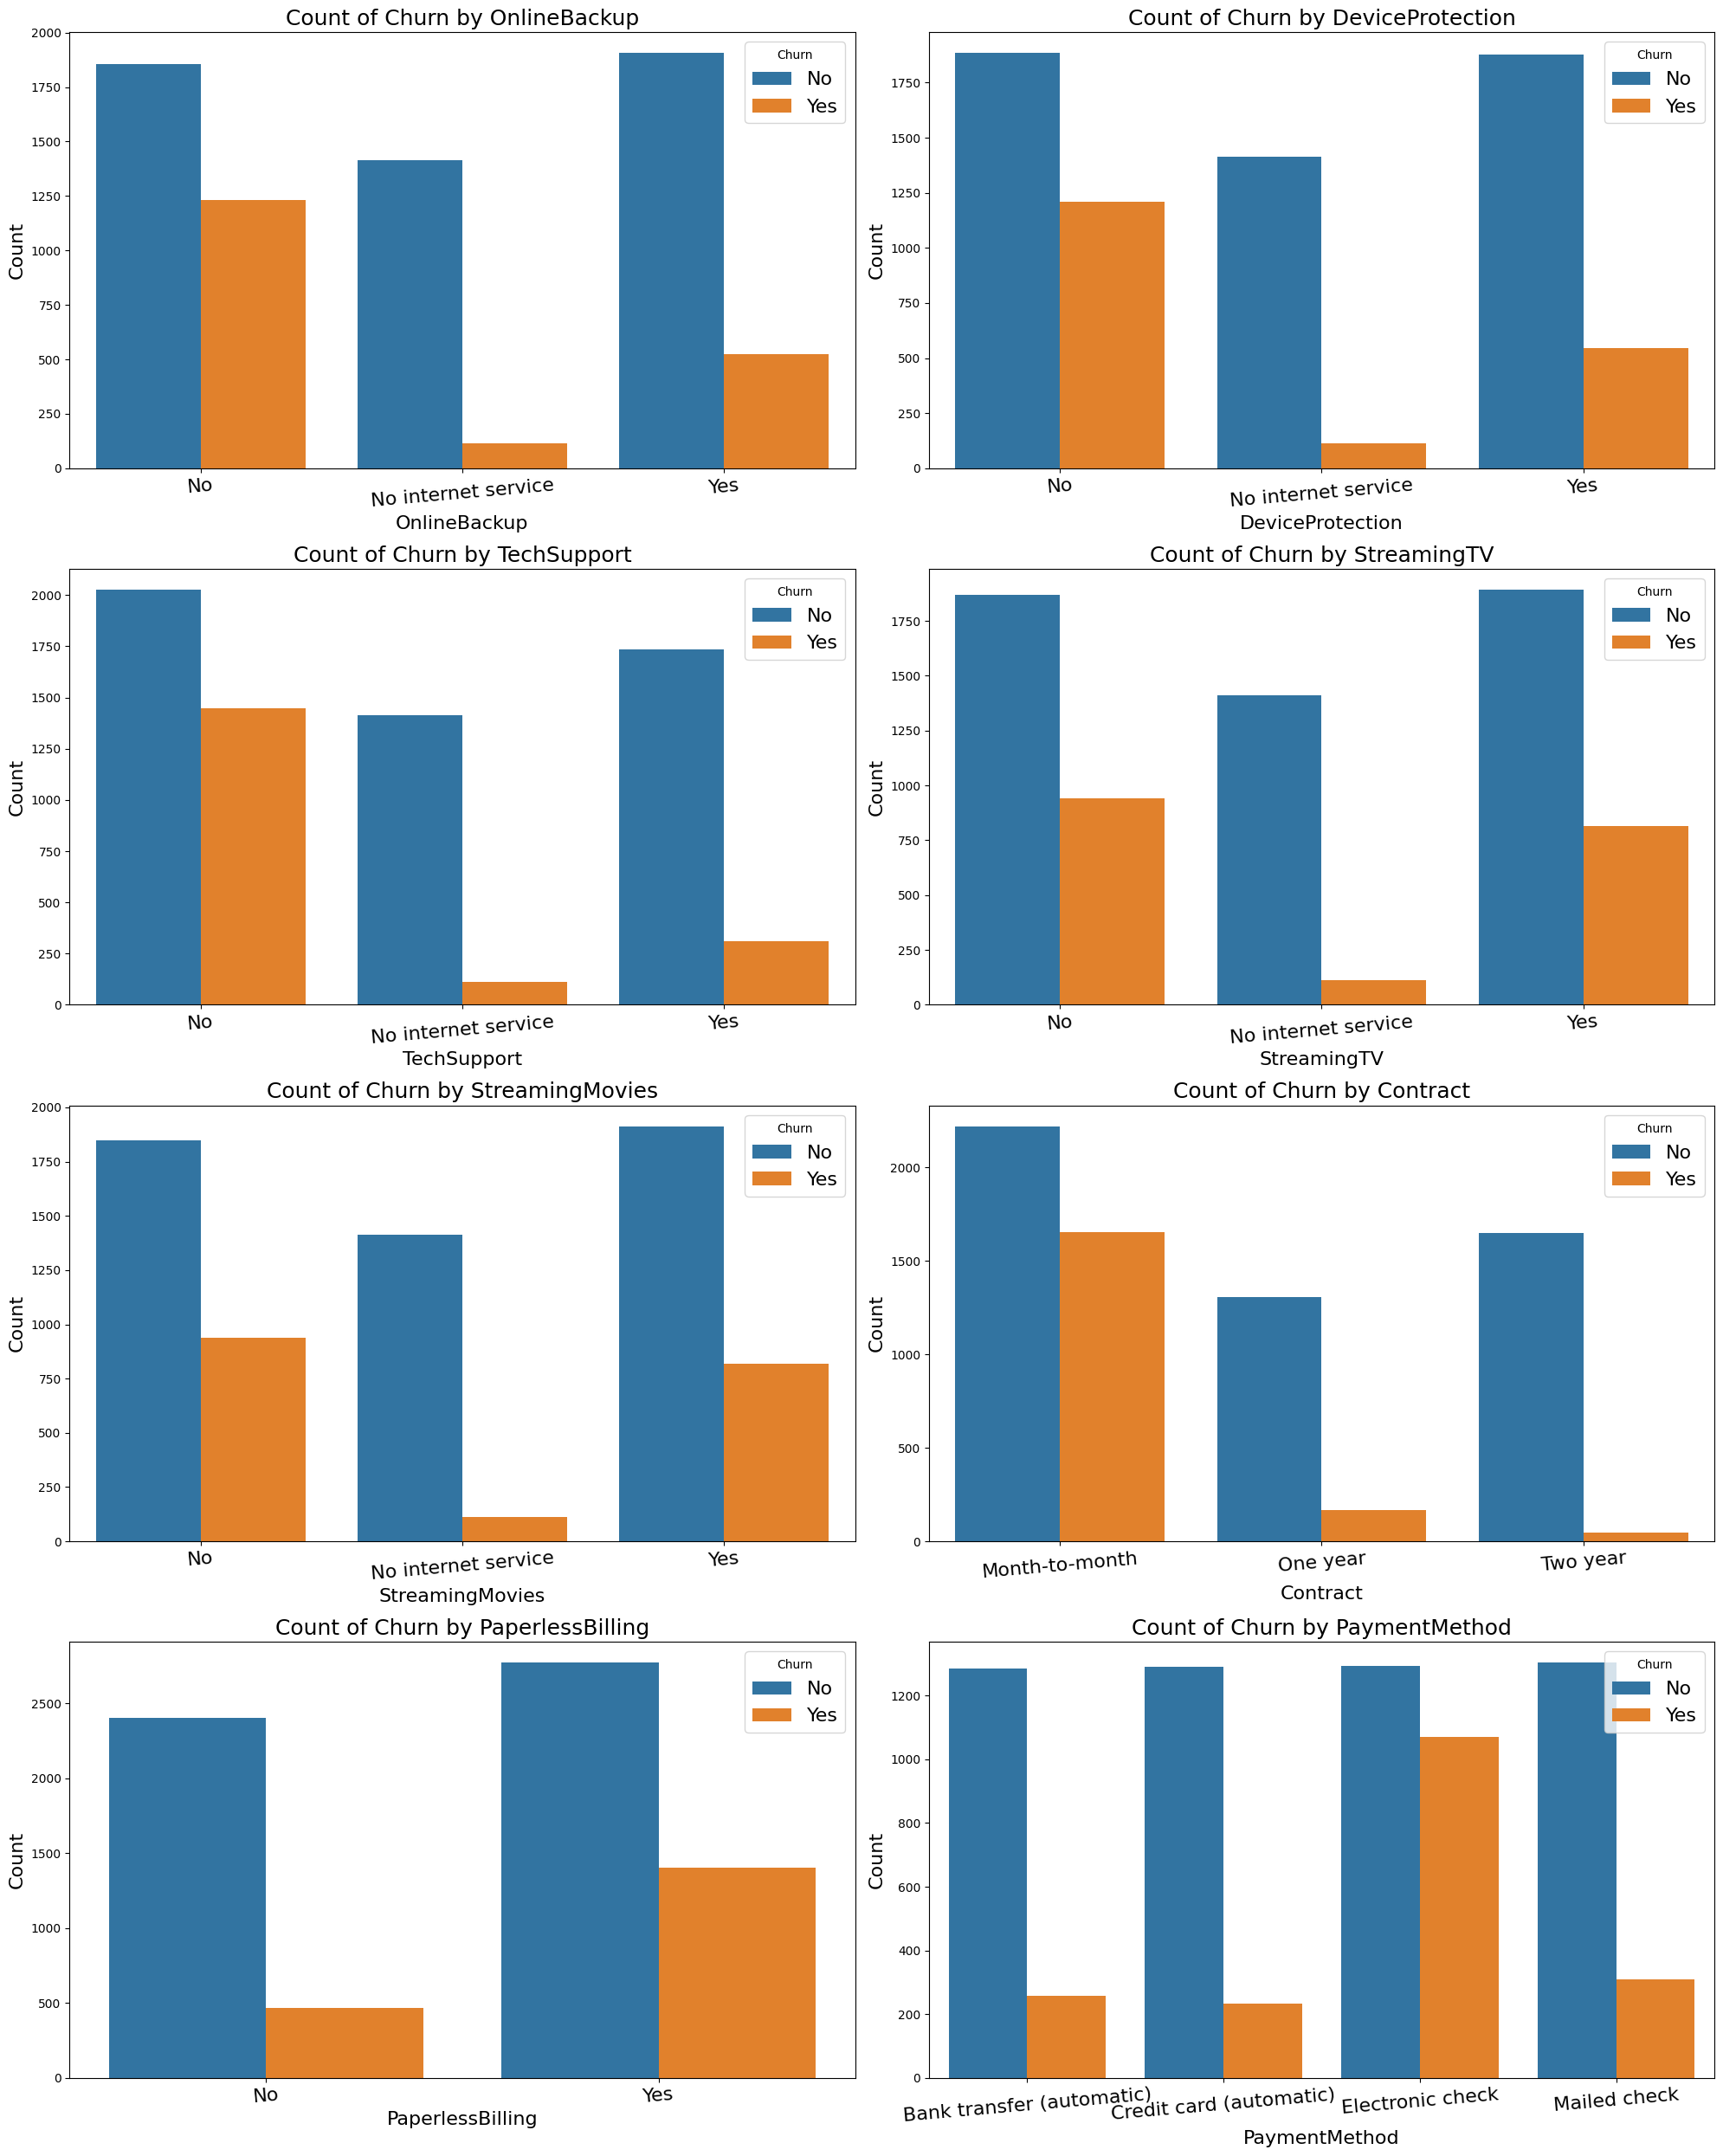

In [17]:
#Visualising the categorical features 
print('\033[1mCategorical features count w.r.t target:'.center(100))
plt.figure(figsize=[20,25])
y_name=target

for i, col_name in enumerate(cf[8:]):
    plt.subplot(4,2,i+1)
    
    # Count the occurrences of each combination of categories
    x_name = col_name
    count_df = original_df.groupby([y_name, x_name]).size().reset_index(name='Count')
    sns.barplot(x=x_name, y='Count', hue=y_name, data=count_df)
    
    plot_title = 'Count of ' + y_name + ' by ' + x_name
    plt.title(plot_title, fontsize=18)
    plt.xlabel(x_name, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.legend(title=y_name, fontsize=16)        
    plt.xticks(rotation=5, fontsize=16)

plt.tight_layout()
plt.show()

**Inference:**

- Customers who had services like online backup, device protection, and technical support tended to leave less often.

- There's a significant churn rate among customers with Month-to-Month contracts. This might be due to customers trying out different services available to them. They might opt for the 1-month plan to explore services without committing long-term.

- Many customers who opted for PaperlessBilling ended up churning. This could be due to potential payment or receipt issues.

- The high churn rate associated with the Electronic check PaymentMethod suggests that customers didn't like this method. The company should consider either discontinuing the Electronic check option or improving its user-friendliness to reduce churn.

#### Target variable vs Input Numerical Feature

                                           Numerical features boxplot w.r.t target                                            


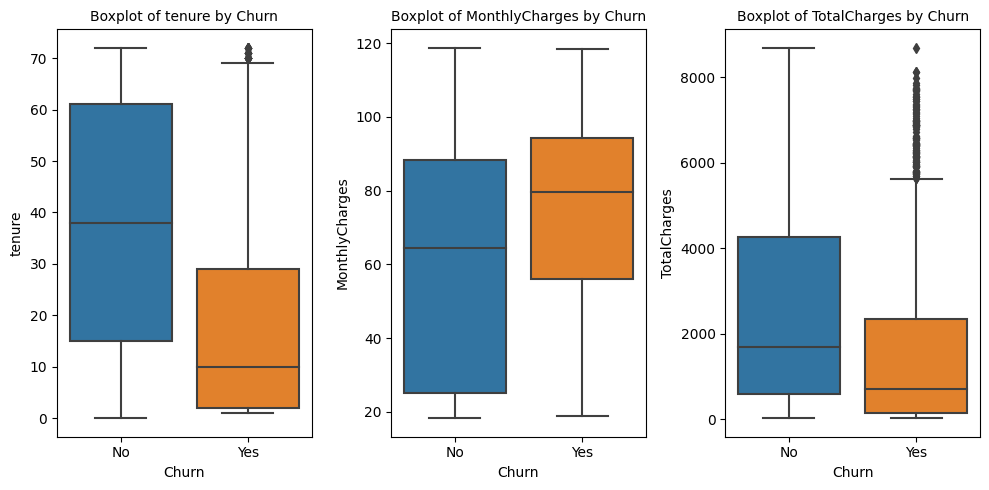

In [48]:
#Visualising the numeric features 

print('\033[1mNumerical features boxplot w.r.t target'.center(130))

ncols = len(nf)

plt.figure(figsize=[10,5])

for i, col in enumerate(nf):
    plt.subplot(1,ncols,i+1)
    sns.boxplot(x=target, y=col, data=original_df)
    
    plot_title = 'Boxplot of ' + col + ' by ' + target
    plt.title(plot_title, fontsize=10)
    plt.xlabel(target, fontsize=10)
    plt.ylabel(col, fontsize=10)
    
plt.tight_layout()
plt.show()

**Inference:**

- Customers who stayed with the company for a longer time didn't leave, unlike those who churned. The company should talk to these customers to find out why they're leaving.
- Customers who decided to leave paid more for their monthly charges. To keep customers, the company could consider lowering these monthly costs.
- Customers who left had lower total charges. Maybe this is because they didn't use the service for as long.

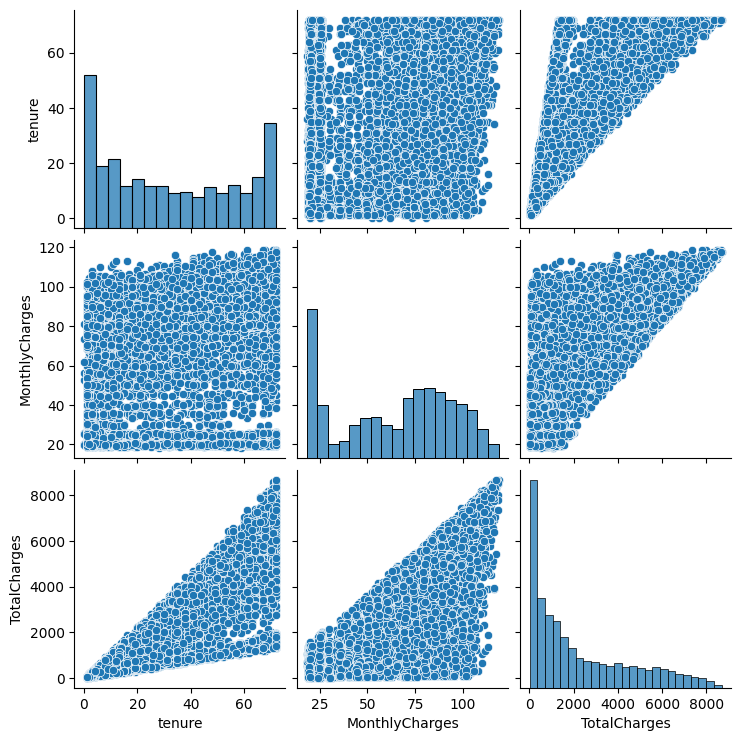

In [55]:
#Understanding the relationship between all the features

g = sns.pairplot(original_df[nf])
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)  # Adjust fontsize as needed
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)  # Adjust fontsize as needed
    
plt.show()

                           Correlation Matrix with unscaled data                            


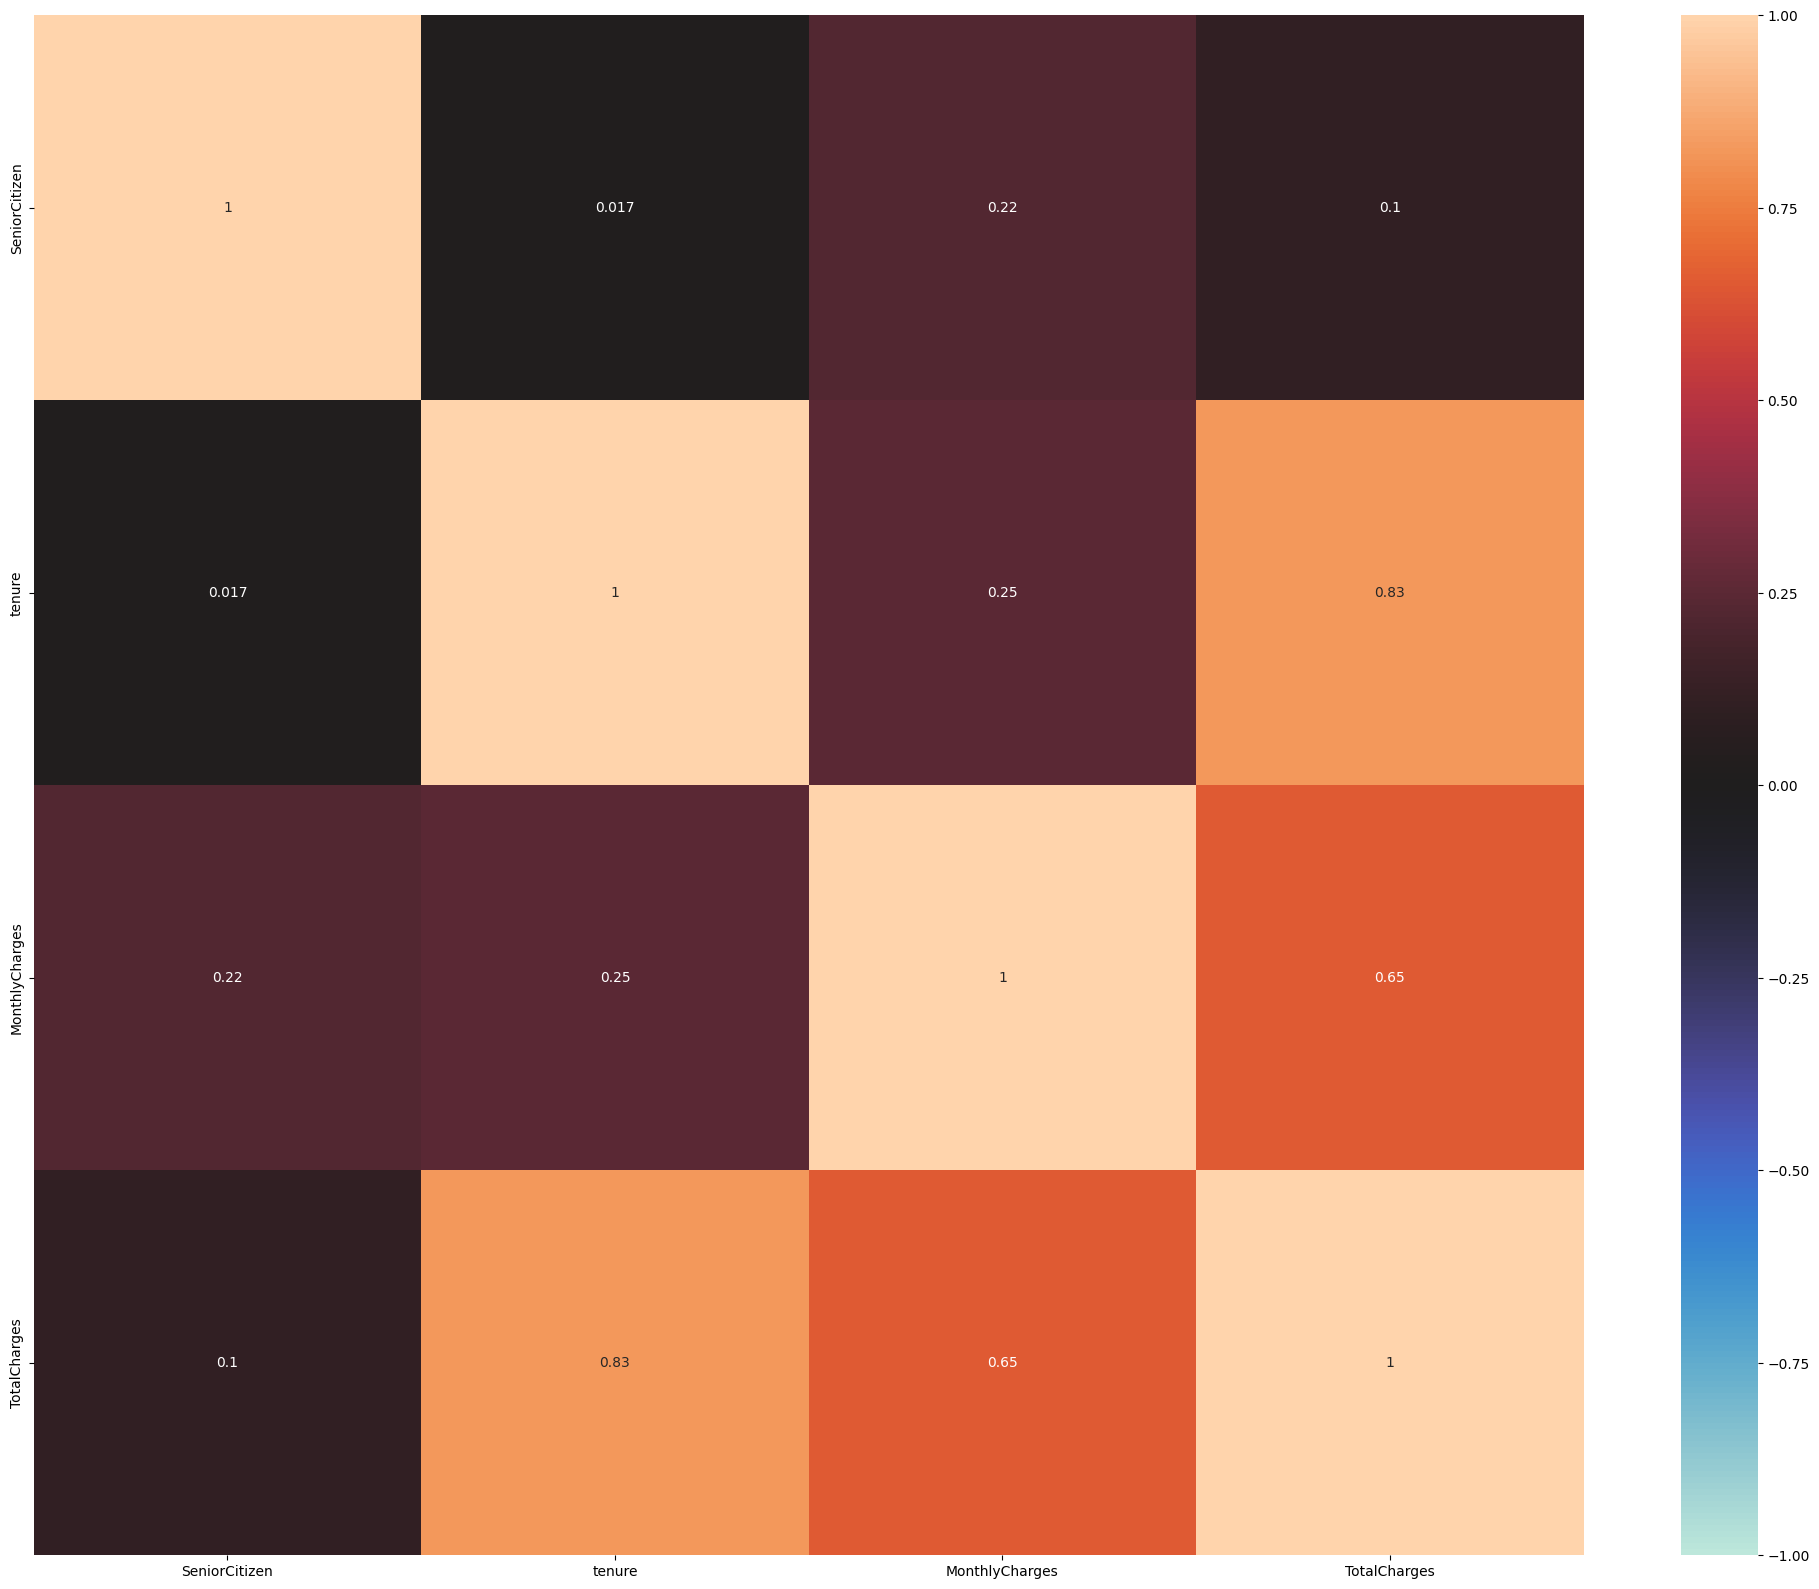

In [53]:
#Checking the correlation

print('\033[1mCorrelation Matrix with unscaled data\033[0m'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(original_df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

Total Charges is correlated with Monthly Charges and Tenure.

#### Boxplot of tenure by categorical features

                           Boxplot of tenure by categorical features:                           


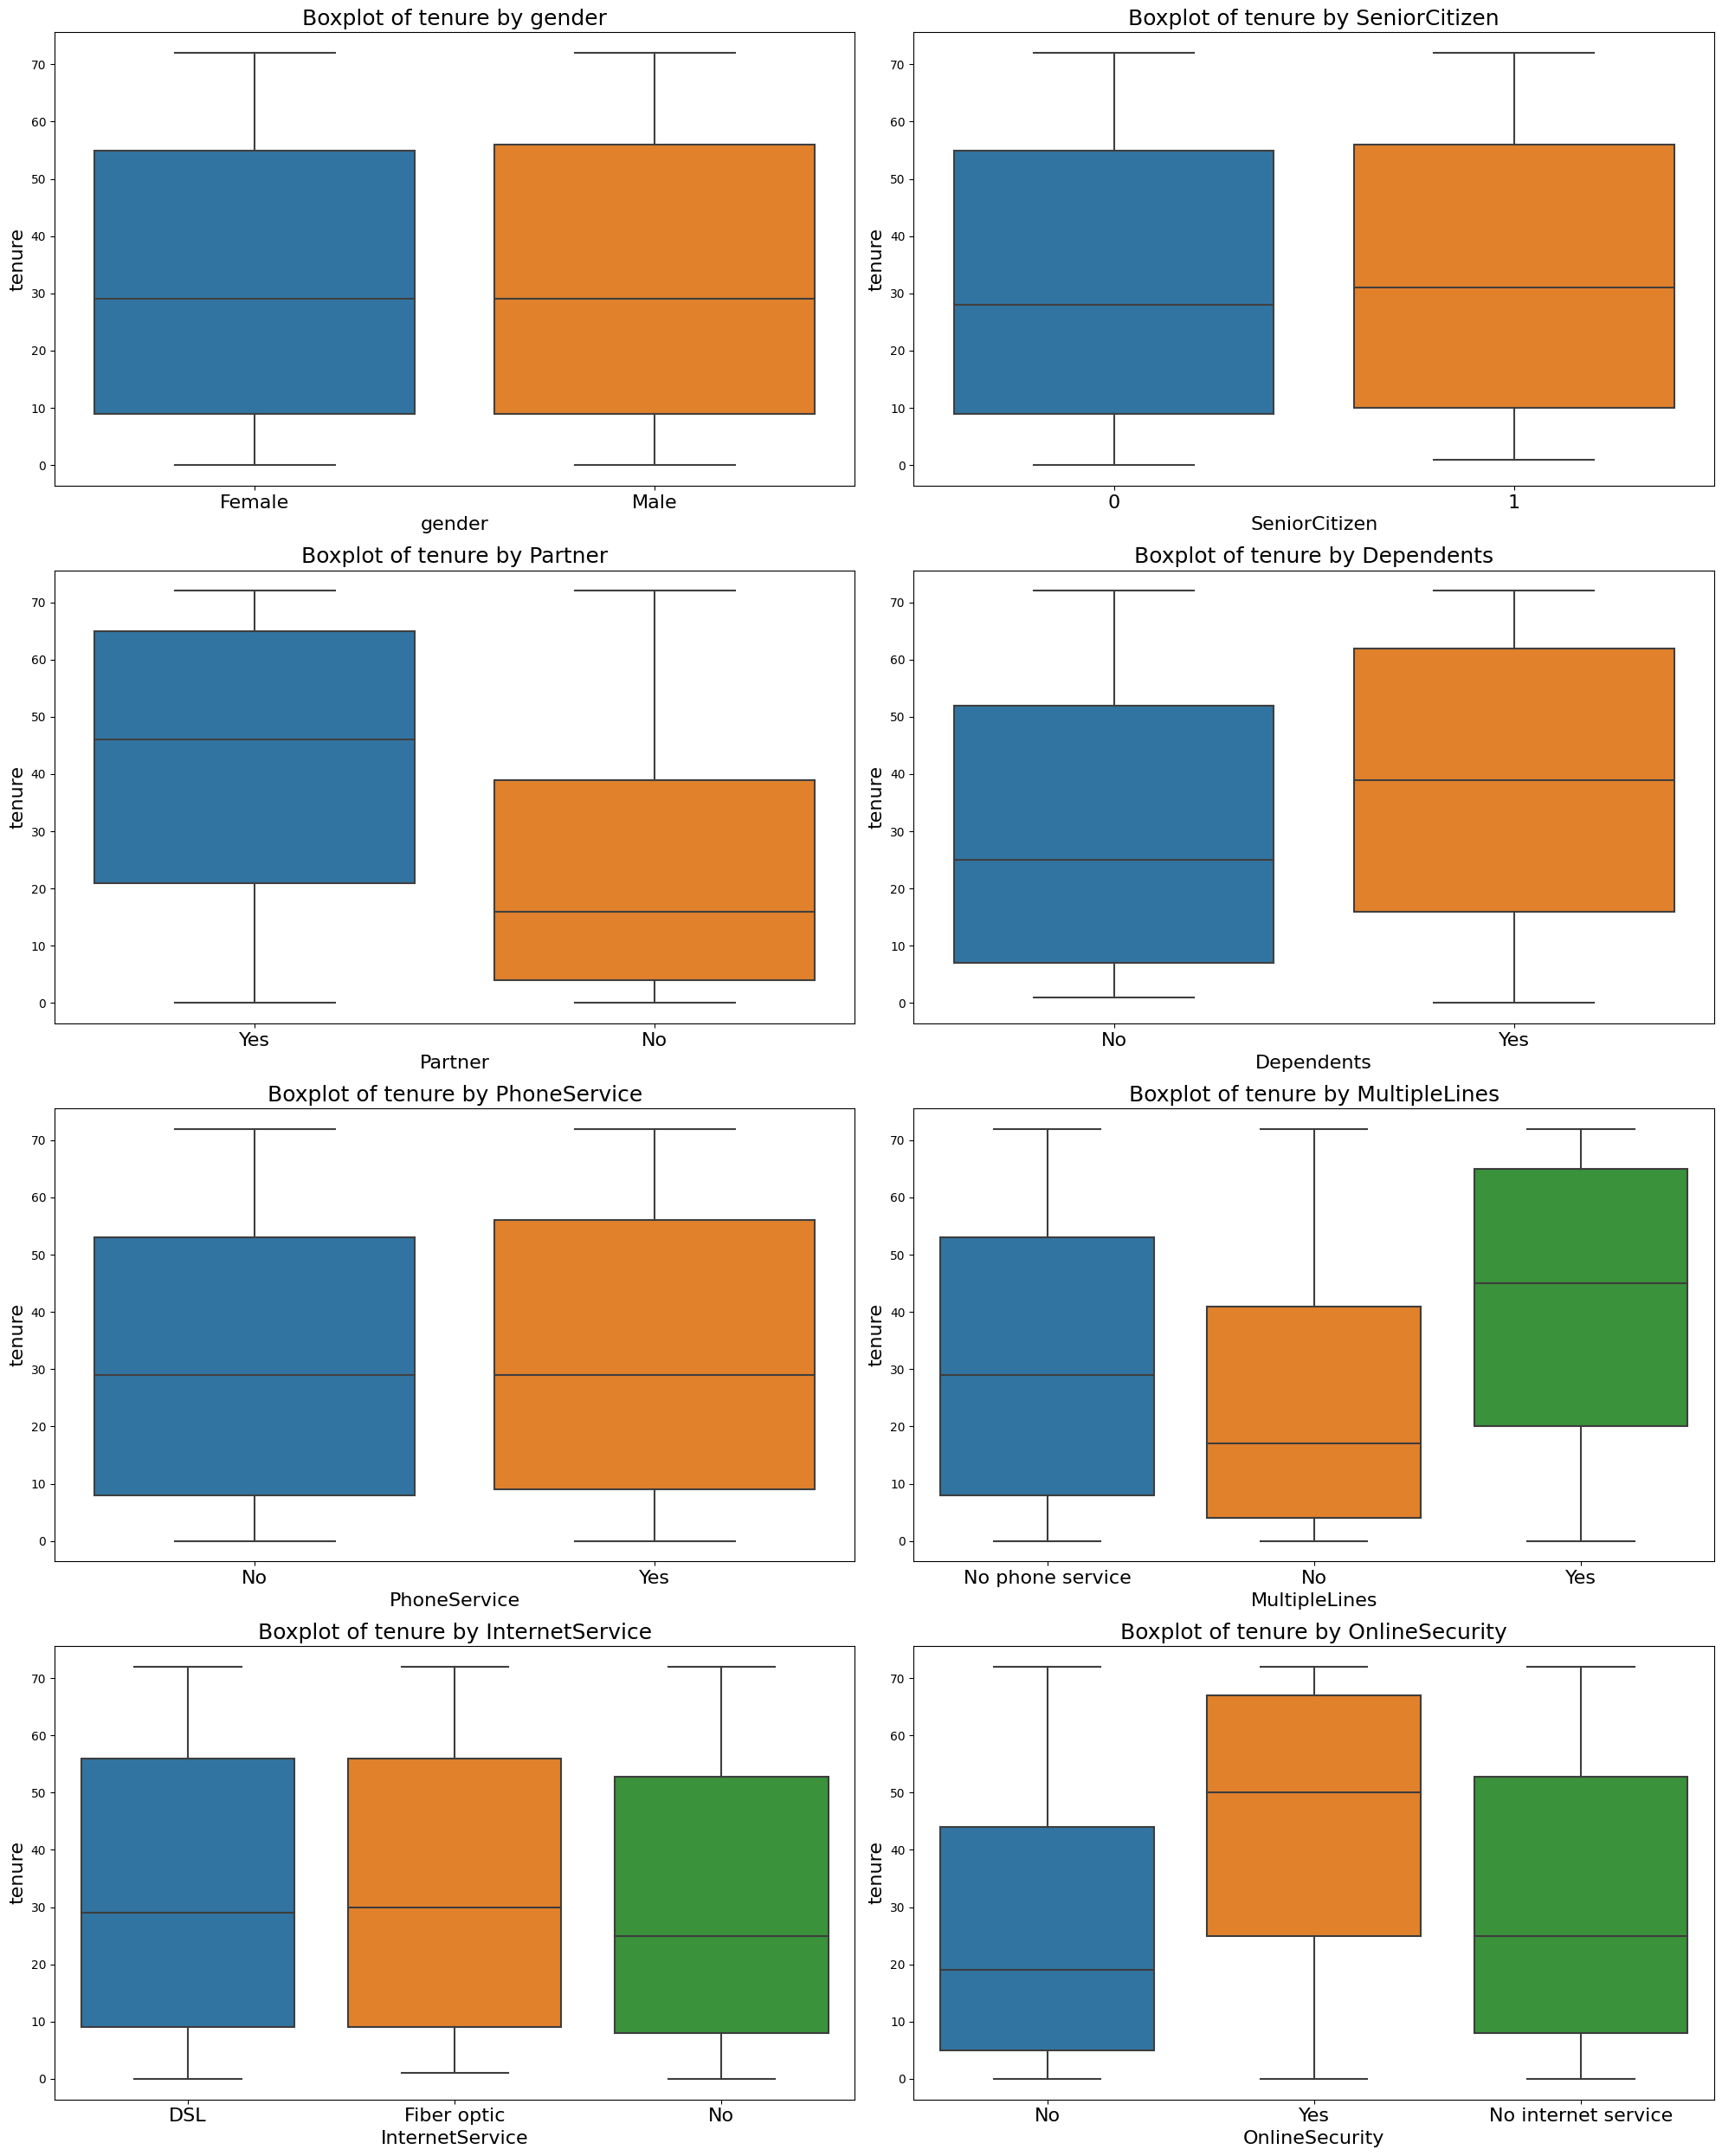

In [57]:
#Visualising the categorical features 
print('\033[1mBoxplot of tenure by categorical features:'.center(100))
plt.figure(figsize=[20,25])

for i, col_name in enumerate(cf[:8]):
    plt.subplot(4,2,i+1)
    sns.boxplot(x=col_name, y='tenure', data=original_df)
    
    plot_title = 'Boxplot of tenure by ' + col_name
    plt.title(plot_title, fontsize=18)
    plt.xlabel(col_name, fontsize=16)
    plt.ylabel('tenure', fontsize=16)
    plt.xticks(rotation=0, fontsize=16)
    
plt.tight_layout()
plt.show()

**Inference:**

- Customers with partners and dependents tend to stay longer compared to those without. Therefore, the company should focus on attracting customers with a partner and/or dependents.
- There's not much difference in the tenure between male and female customers.
- Senior citizen customers have slightly higher tenure compared to non-senior citizens.
- Customers who have online security and multiple lines also show higher tenure. Hence, the company should prioritize maintaining the quality of these services.

                           Boxplot of tenure by categorical features:                           


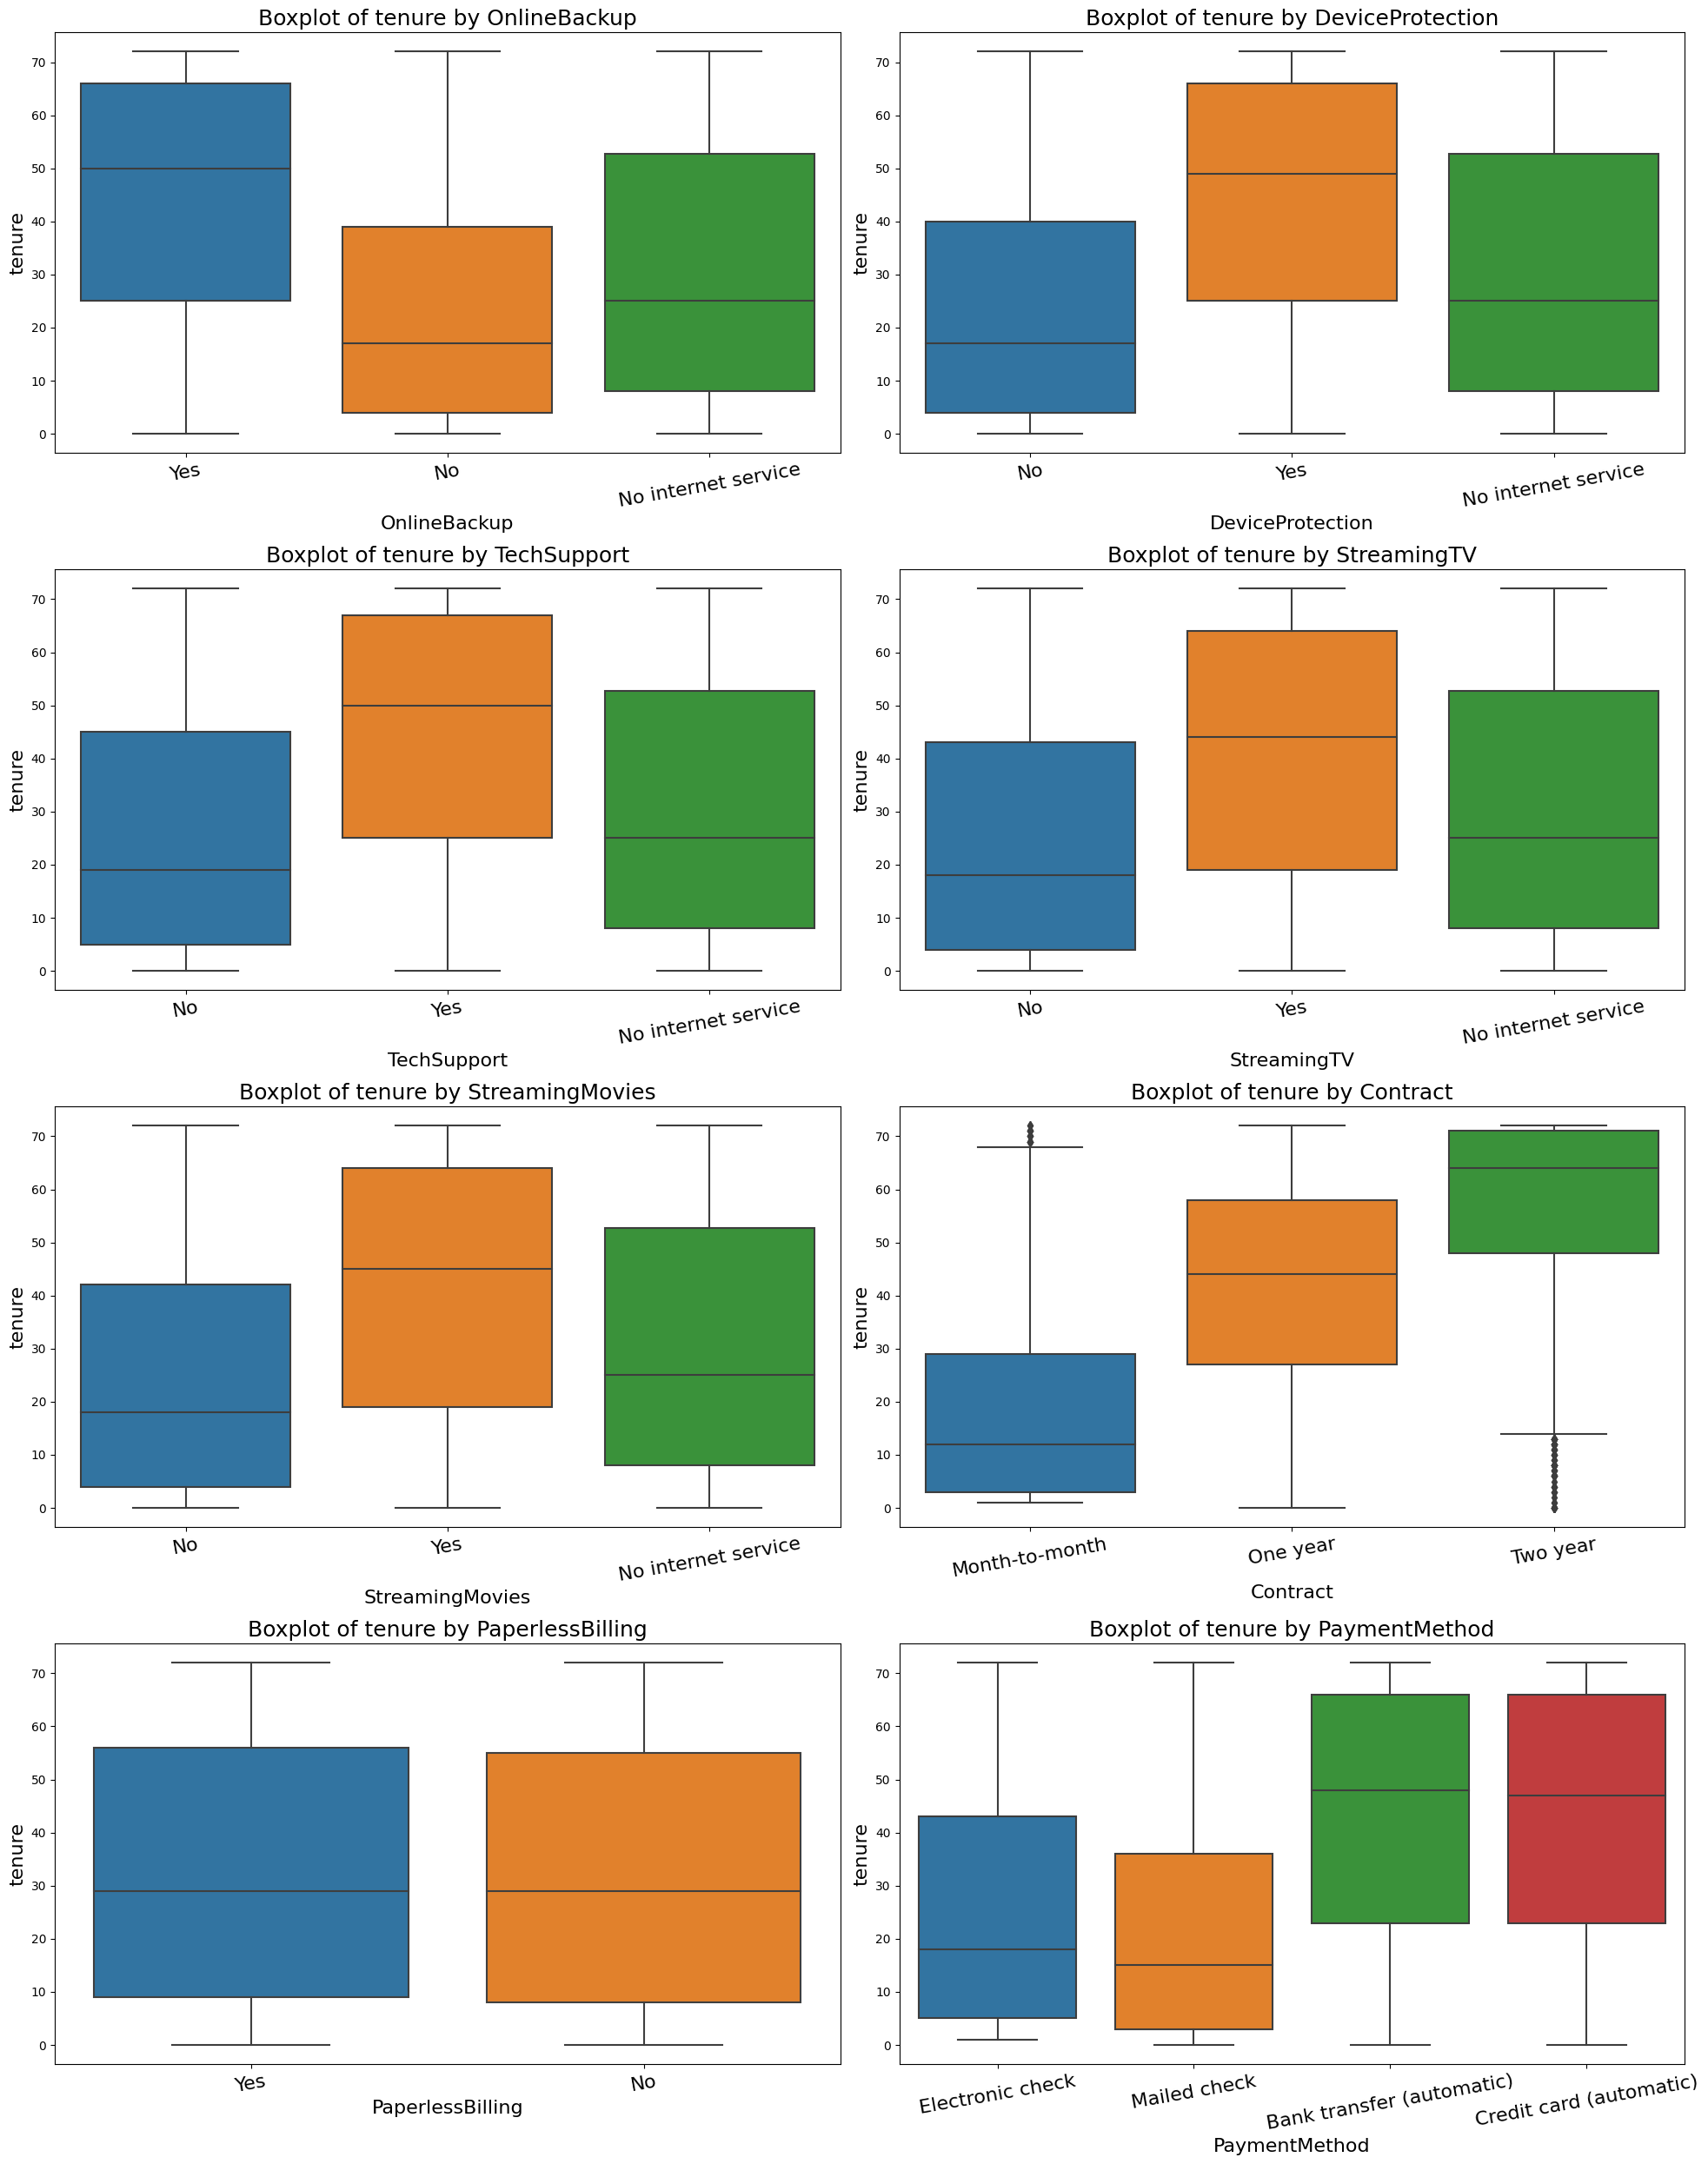

In [59]:
#Visualising the categorical features 
print('\033[1mBoxplot of tenure by categorical features:'.center(100))
plt.figure(figsize=[20,25])

for i, col_name in enumerate(cf[8:]):
    plt.subplot(4,2,i+1)
    sns.boxplot(x=col_name, y='tenure', data=original_df)
    
    plot_title = 'Boxplot of tenure by ' + col_name
    plt.title(plot_title, fontsize=18)
    plt.xlabel(col_name, fontsize=16)
    plt.ylabel('tenure', fontsize=16)
    plt.xticks(rotation=10, fontsize=16)
    
plt.tight_layout()
plt.show()

**Inference:**

- Customers who use services like streaming, technical support, device protection, and online backup tend to stay with the company longer compared to those who don't use these services. It looks like when a customer sticks with any service, they tend to stay connected with the company for a longer time.

- As we expected, customers who choose a two-year service have a longer tenure compared to those who go for a one-year service. On the other hand, customers who opt for a month-to-month service have the shortest tenure.

- It seems that having paperless billing doesn't have a noticeable impact on the tenure of customers.

- Customers who use bank transfer or credit card as their payment method tend to stay with the company for a longer duration.

## 4. Data Preprocessing

In [12]:
df = original_df.copy()

In [13]:
# Dropping the customerID column

df.drop(['customerID'], axis=1, inplace=True) 

### 1. Removing duplicate rows

In [14]:
#Removing duplicate rows

rs,cs = df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\nThe dataset doesn\'t have any duplicates')
else:
    print(f'\n{rs-df.shape[0]} duplicate samples were dropped from the dataset.')


22 duplicate samples were dropped from the dataset.


### 2. Handling null values

In [15]:
# Check for null counts

null_cnt = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
null_cnt['Percentage'] = round(null_cnt['Total Null Values']/df.shape[0],3)*100
null_cnt.sort_values(by=['Percentage'], ascending=False)

,Total Null Values,Percentage
TotalCharges,11,0.2
MonthlyCharges,0,0.0
Churn,0,0.0
SeniorCitizen,0,0.0
Partner,0,0.0
Dependents,0,0.0
tenure,0,0.0
PhoneService,0,0.0
MultipleLines,0,0.0
InternetService,0,0.0


In [16]:
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

### 3. Label Encoding

In [17]:
# One-Hot encoding the categorical features

for i in cf:    
    df=pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], drop_first=True, prefix=str(i)))],axis=1)
        
df.shape

(7021, 31)

In [18]:
# Replacing Yes/No with 1/0 in target column

df[target] = df[target].replace({'Yes': 1, 'No': 0})

In [19]:
temp = nf+[target]
new_cf=[i for i in df.columns if i not in temp] # New categorical features

## 5. Data Manipulation

In [20]:
# splitting for train and test
X = df.drop(target,axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,
      '\nTraining set  ---> ',Train_X.shape,Train_Y.shape,
      '\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (7021, 30) (7021,) 
Training set  --->  (5616, 30) (5616,) 
Testing set   --->  (1405, 30)  (1405,)


## 6. Feature Selection

### 1. Checking for correlation among features and removing correlated features

In [21]:
def check_correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(dataset.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                
    return col_corr

In [22]:
pearson_corr_threshold=0.65
corr_features=list(check_correlation(Train_X, pearson_corr_threshold)) # features that are highly correlated with other features
corr_features

['InternetService_Fiber optic',
 'OnlineBackup_No internet service',
 'StreamingMovies_No internet service',
 'StreamingTV_No internet service',
 'TotalCharges',
 'InternetService_No',
 'MultipleLines_No phone service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'OnlineSecurity_No internet service']

In [23]:
# Dropping the features that are correlated with each other
Train_X.drop(corr_features, axis=1, inplace=True)

In [24]:
# Updating the list of numerical and categorical features
new_cf = [i for i in new_cf if i not in corr_features]
new_nf = [i for i in nf if i not in corr_features]

### 2. Feature Importance

In [25]:
# Selecting the top 10 categorical features
selection = SelectKBest(chi2)  # k=10 default
selection.fit_transform(Train_X[new_cf], Train_Y)
selected_feature_indices = selection.get_support()
feat=selection.feature_names_in_
# print(feat)
# Get the names of the selected features
selected_cat_features = list(feat[selected_feature_indices])

# print("Selected feature indices:", selected_feature_indices)
print("Selected feature names: " +", ".join(selected_cat_features))

Selected feature names: SeniorCitizen_1, Partner_Yes, Dependents_Yes, OnlineSecurity_Yes, TechSupport_Yes, Contract_One year, Contract_Two year, PaperlessBilling_Yes, PaymentMethod_Credit card (automatic), PaymentMethod_Electronic check


In [26]:
new_cf = selected_cat_features

In [27]:
selected_features = new_nf + new_cf
selected_features

['tenure',
 'MonthlyCharges',
 'SeniorCitizen_1',
 'Partner_Yes',
 'Dependents_Yes',
 'OnlineSecurity_Yes',
 'TechSupport_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check']

In [28]:
Train_X=Train_X[selected_features]
Train_X.head()

,tenure,MonthlyCharges,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,23,79.35,1,0,0,0,0,0,0,1,0,0
1,1,80.00,0,1,1,0,0,0,0,0,0,1
2,10,95.25,0,0,0,0,0,0,0,1,0,1
3,18,80.65,0,0,0,0,0,0,0,1,0,1
4,64,111.45,0,1,1,0,1,1,0,1,0,1


In [29]:
Test_X=Test_X[selected_features]
Test_X.head()

,tenure,MonthlyCharges,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
4411,57,49.90,0,1,0,1,1,0,0,1,0,0
931,33,80.60,0,0,0,0,1,0,1,0,0,0
1371,1,79.20,1,0,0,0,0,0,0,1,0,1
4852,69,20.30,1,0,0,0,0,0,1,0,1,0
5179,3,69.35,0,0,0,0,1,0,0,1,0,1


## 7. Feature Scaling

In [30]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler() 

print('\033[1mScaling train set data'.center(120))
Train_X_std = mms.fit_transform(Train_X[new_nf])
Train_X_std = pd.concat([pd.DataFrame(Train_X_std, columns=new_nf).reset_index(drop=True), 
                         Train_X[new_cf].reset_index(drop=True)],axis = 1)
display(Train_X_std.describe())

print('\n','\033[1mScaling test set data'.center(120))
Test_X_std = mms.transform(Test_X[new_nf])
Test_X_std = pd.concat([pd.DataFrame(Test_X_std, columns=new_nf).reset_index(drop=True), 
                        Test_X[new_cf].reset_index(drop = True)], axis=1)
display(Test_X_std.describe())

                                               Scaling train set data                                               


,tenure,MonthlyCharges,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
count,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000,5616.000000
mean,0.447729,0.464992,0.162749,0.489316,0.303597,0.287749,0.289352,0.209758,0.237714,0.594551,0.212963,0.334936
std,0.339896,0.299152,0.369170,0.499930,0.459852,0.452754,0.453502,0.407172,0.425721,0.491022,0.409438,0.472010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125000,0.176617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.402778,0.519900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.763889,0.713060,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



                                                Scaling test set data                                                


,tenure,MonthlyCharges,SeniorCitizen_1,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
count,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000,1405.000000
mean,0.463899,0.458539,0.161566,0.465480,0.288256,0.286833,0.298221,0.209964,0.256228,0.585053,0.232028,0.340214
std,0.344026,0.299414,0.368183,0.498985,0.453112,0.452444,0.457640,0.407428,0.436705,0.492888,0.422277,0.473950
min,0.013889,0.004478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125000,0.163682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.430556,0.514428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.791667,0.711940,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,0.994527,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 8. Predictive Modelling

In [31]:
df_model_compare=pd.DataFrame(columns = ['Train Accuracy', 'Test Accuracy', 'F1-Score', 'Recall', 'Precision', 'ROC-AUC'])
roc_data=dict()

## Dummy Classifier

In [32]:
from sklearn.dummy import DummyClassifier

dmc = DummyClassifier(random_state=0).fit(Train_X_std,Train_Y)
y_train_pred = dmc.predict(Train_X_std)
y_test_pred = dmc.predict(Test_X_std)
y_test_prob = dmc.predict_proba(Test_X_std)[:,1]
classifier_name='Dummy Classifier'

print("\033[1m"+classifier_name+": \033[0m")

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(Train_Y, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

Dummy Classifier: 

Classification Report: 
              precision    recall  f1-score   support

          No       0.74      1.00      0.85      1033
         Yes       0.00      0.00      0.00       372

    accuracy                           0.74      1405
   macro avg       0.37      0.50      0.42      1405
weighted avg       0.54      0.74      0.62      1405


For training data: 
The accuracy of the model is 0.736 and its F1 score is 0.000.

For test data: 
The accuracy of the model is 0.735 and its F1 score is 0.000.


In [45]:
from sklearn.linear_model import LogisticRegression
classifier_name='Logistic Regression'

logreg = LogisticRegression(solver='newton-cholesky', random_state=0)

# fit the model
logreg.fit(Train_X_std, Train_Y)
y_train_pred = logreg.predict(Train_X_std)
y_test_pred = logreg.predict(Test_X_std)
y_test_prob = logreg.predict_proba(Test_X_std)[:,1]

print("\033[1m"+classifier_name+": \033[0m")

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(Train_Y, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

Logistic Regression: 

Classification Report: 
              precision    recall  f1-score   support

          No       0.84      0.92      0.88      1033
         Yes       0.70      0.52      0.60       372

    accuracy                           0.81      1405
   macro avg       0.77      0.72      0.74      1405
weighted avg       0.81      0.81      0.81      1405


For training data: 
The accuracy of the model is 0.795 and its F1 score is 0.564.

For test data: 
The accuracy of the model is 0.815 and its F1 score is 0.598.


In [46]:
from sklearn.ensemble import RandomForestClassifier
classifier_name = 'Random Forest'

rfc = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=10, 
                             min_samples_split=6, n_jobs=-1, random_state=0)

rfc.fit(Train_X_std, Train_Y)

y_train_pred = rfc.predict(Train_X_std)
y_test_pred = rfc.predict(Test_X_std)
y_test_prob = rfc.predict_proba(Test_X_std)[:,1]

print("\033[1m"+classifier_name+": \033[0m")
print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(Train_Y, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

Random Forest: 

Classification Report: 
              precision    recall  f1-score   support

          No       0.84      0.93      0.88      1033
         Yes       0.71      0.51      0.59       372

    accuracy                           0.82      1405
   macro avg       0.78      0.72      0.74      1405
weighted avg       0.81      0.82      0.80      1405


For training data: 
The accuracy of the model is 0.826 and its F1 score is 0.617.

For test data: 
The accuracy of the model is 0.816 and its F1 score is 0.595.


### Using SMOTENC for imbalance dataset:

In [33]:
cat_feats=[i for i in range(len(Train_X_std.columns)) if i not in [0,1]]
cat_feats

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [34]:
st=SMOTENC(categorical_features=cat_feats, sampling_strategy=0.75)
X_train_st,y_train_st = st.fit_resample(Train_X_std, Train_Y)
print("The number of classes before fit {}".format(Counter(Train_Y)))
print("The number of classes after fit {}".format(Counter(y_train_st)))

The number of classes before fit Counter({0: 4131, 1: 1485})
The number of classes after fit Counter({0: 4131, 1: 3098})


In [54]:
classifier_name='Logistic Regression'

logreg = LogisticRegression(solver='newton-cholesky', random_state=0)

# fit the model
logreg.fit(X_train_st, y_train_st)
y_train_pred = logreg.predict(X_train_st)
y_test_pred = logreg.predict(Test_X_std)
y_test_prob = logreg.predict_proba(Test_X_std)[:,1]

print("\033[1m"+classifier_name+": \033[0m")

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

Logistic Regression: 

Classification Report: 
              precision    recall  f1-score   support

          No       0.90      0.81      0.85      1033
         Yes       0.58      0.74      0.65       372

    accuracy                           0.79      1405
   macro avg       0.74      0.77      0.75      1405
weighted avg       0.81      0.79      0.80      1405


For training data: 
The accuracy of the model is 0.764 and its F1 score is 0.729.

For test data: 
The accuracy of the model is 0.788 and its F1 score is 0.649.


In [55]:
classifier_name = 'Random Forest'

rfc = RandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=10, 
                             min_samples_split=6, n_jobs=-1, random_state=0)

rfc.fit(X_train_st, y_train_st)

y_train_pred = rfc.predict(X_train_st)
y_test_pred = rfc.predict(Test_X_std)
y_test_prob = rfc.predict_proba(Test_X_std)[:,1]

print("\033[1m"+classifier_name+": \033[0m")
print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

Random Forest: 

Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.83      0.86      1033
         Yes       0.59      0.70      0.64       372

    accuracy                           0.79      1405
   macro avg       0.74      0.76      0.75      1405
weighted avg       0.81      0.79      0.80      1405


For training data: 
The accuracy of the model is 0.830 and its F1 score is 0.803.

For test data: 
The accuracy of the model is 0.794 and its F1 score is 0.644.


The F1 score for the test set seems to improve on using a model that has been fitted on the training set transformed using SMOTENC. So, we will be using the transformed training dataset i.e. (X_train_st, y_train_st) to fit our model.

### Logistic Regression

Logistic Regression: 

The best parameter values are:

Penalty used: l2
Inverse of regularization strength: 0.1
Elastic-Net mixing parameter: 0

Classification Report: 
              precision    recall  f1-score   support

          No       0.90      0.80      0.84      1033
         Yes       0.57      0.74      0.64       372

    accuracy                           0.78      1405
   macro avg       0.73      0.77      0.74      1405
weighted avg       0.81      0.78      0.79      1405


For training data: 
The accuracy of the model is 0.767 and its F1 score is 0.734.

For test data: 
The accuracy of the model is 0.784 and its F1 score is 0.645.

 [0.767 0.784 0.645 0.742 0.57  0.86  0.742]


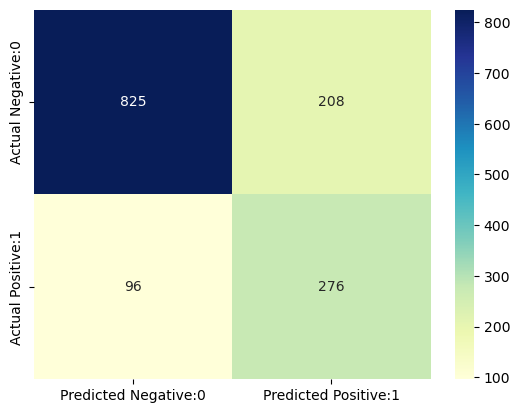

In [134]:
from sklearn.linear_model import LogisticRegression

classifier_name='Logistic Regression'
lrc = LogisticRegression(solver='saga', n_jobs=-1, random_state=0)

# Define the parameter grid to search for the best hyperparameters
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  
    'C': [0.01, 0.1, 1, 10, 100],                 # Range of regularization strengths
    'l1_ratio': [0, 0.2, 0.5, 0.8]                   # Elastic Net mixing ratios (while using penalty='elasticnet')
}

# Initialize GridSearchCV with the LogisticRegression, parameter grid, and f1 as scoring
grid_search = GridSearchCV(estimator=lrc, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best hyperparameters using cross-validation
grid_search.fit(X_train_st, y_train_st)

# Get the best k value and its corresponding mean squared error
best_params = grid_search.best_params_

print("\033[1m"+classifier_name+": \033[0m")
print(f"\nThe best parameter values are:")
print(f"\nPenalty used: {best_params['penalty']}")
print(f"Inverse of regularization strength: {best_params['C']}")
print(f"Elastic-Net mixing parameter: {best_params['l1_ratio']}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### SVM

SVC linear: 

The best parameter values are:

Regularization parameter, C: 0.01
Kernel: linear

Classification Report: 
              precision    recall  f1-score   support

          No       0.91      0.76      0.83      1033
         Yes       0.54      0.78      0.64       372

    accuracy                           0.77      1405
   macro avg       0.72      0.77      0.73      1405
weighted avg       0.81      0.77      0.78      1405


For training data: 
The accuracy of the model is 0.763 and its F1 score is 0.741.

For test data: 
The accuracy of the model is 0.768 and its F1 score is 0.640.

 [0.763 0.768 0.64  0.78  0.543 0.855 0.78 ]


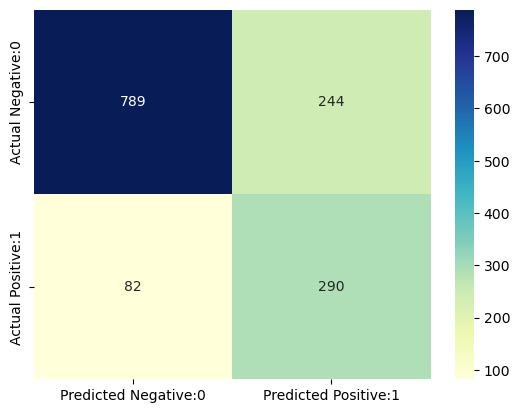

In [161]:
from sklearn.svm import SVC

classifier_name = 'SVC'
svc = SVC(probability = True, random_state=0)

# Define the parameter grid to search for the best C and penalty
param_grid = {
    'C': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }

#  'gamma': ['scale', 'auto', 0.1, 1]
# Initialize GridSearchCV with the LinearSVC, parameter grid, and f1 as scoring
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best hyperparameters using cross-validation
grid_search.fit(X_train_st, y_train_st)

# Best set of parameters
best_params = grid_search.best_params_

best_kernel=best_params['kernel']
classifier_name=classifier_name + ' ' + best_kernel

print("\033[1m"+classifier_name+": \033[0m")
print(f"\nThe best parameter values are:")
print(f"\nRegularization parameter, C: {best_params['C']}")
print(f"Kernel: {best_params['kernel']}")
# print(f"Kernel coefficient, gamma: {best_params['gamma']}")
# print(f"Degree of the polynomial kernel function: {best_params['degree']}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### KNN

KNN: 
Best k value: 30
Best metric is manhattan

Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.78      0.83      1033
         Yes       0.55      0.73      0.62       372

    accuracy                           0.77      1405
   macro avg       0.72      0.76      0.73      1405
weighted avg       0.80      0.77      0.78      1405


For training data: 
The accuracy of the model is 0.777 and its F1 score is 0.751.

For test data: 
The accuracy of the model is 0.767 and its F1 score is 0.625.

 [0.777 0.767 0.625 0.731 0.545 0.834 0.731]


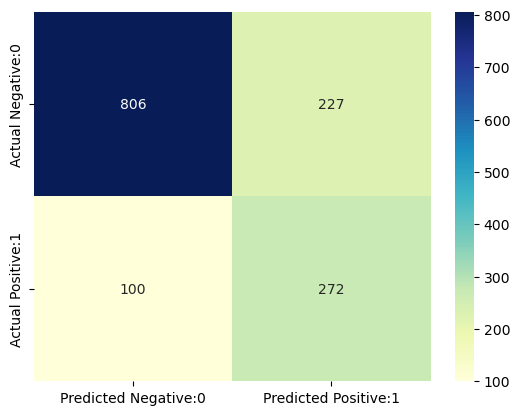

In [158]:
from sklearn.neighbors import KNeighborsClassifier
classifier_name='KNN'

# Create the KNN Classifier model
knn = KNeighborsClassifier(n_jobs=-1)

# Define the parameter grid to search for the best k value
param_grid = {'n_neighbors': [20, 30, 40], # Ensuring that maximum value of k is less than sqrt(N_train_samples)
              'metric': ['minkowski', 'manhattan']} 

# Initialize GridSearchCV with the KNN Regressor, parameter grid, and evaluation metric
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best k value using cross-validation
grid_search.fit(X_train_st, y_train_st)

best_k=grid_search.best_params_['n_neighbors']
best_metric=grid_search.best_params_['metric']

print("\033[1m"+classifier_name+": \033[0m")
print(f"Best k value: {best_k}")
print(f"Best metric is {best_metric}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### Decision Tree Classifier


Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.80      0.85      1033
         Yes       0.57      0.74      0.65       372

    accuracy                           0.79      1405
   macro avg       0.73      0.77      0.75      1405
weighted avg       0.81      0.79      0.79      1405


For training data: 
The accuracy of the model is 0.793 and its F1 score is 0.766.

For test data: 
The accuracy of the model is 0.786 and its F1 score is 0.645.

 [0.793 0.786 0.645 0.737 0.574 0.862 0.737]


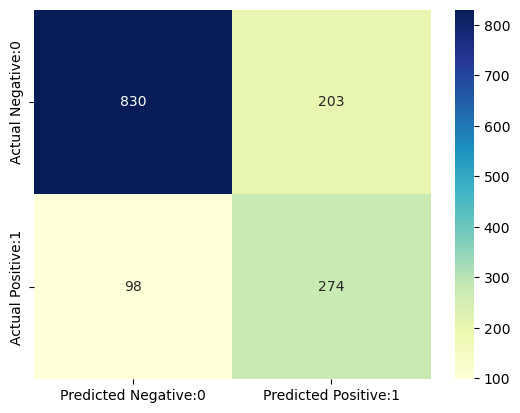

In [138]:
from sklearn.tree import DecisionTreeClassifier
classifier_name = 'Decision Tree'

dtc = DecisionTreeClassifier(max_depth=4, min_samples_split=8, min_samples_leaf=4, random_state=0)

# Fit the model to find the best hyperparameters using cross-validation
dtc.fit(X_train_st, y_train_st)

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

Decision Tree: 

The best parameter values are:
Minimum number of samples to split an internal node: 6
Minimum number of samples required to be at a leaf node: 4

Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.75      0.82      1033
         Yes       0.52      0.75      0.62       372

    accuracy                           0.75      1405
   macro avg       0.71      0.75      0.72      1405
weighted avg       0.80      0.75      0.76      1405


For training data: 
The accuracy of the model is 0.759 and its F1 score is 0.736.

For test data: 
The accuracy of the model is 0.753 and its F1 score is 0.617.

 [0.759 0.753 0.617 0.753 0.523 0.835 0.753]


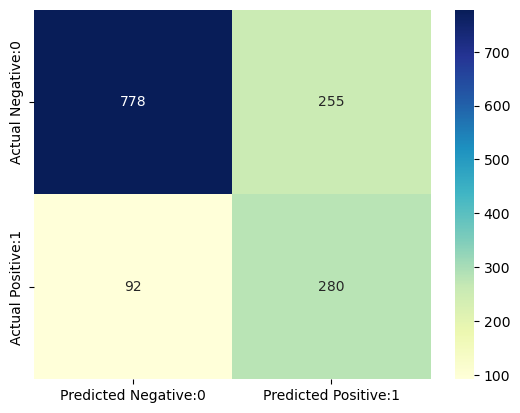

In [157]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=4, random_state=0)

# Define the parameter grid to search for the best hyperparameters
param_grid = {
         'min_samples_split': [6, 8, 10],
         'min_samples_leaf': [4, 6]
}

# Initialize GridSearchCV with the DecisionTreeRegressor, parameter grid, and neg_mean_squared_error as scoring
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best hyperparameters using cross-validation
grid_search.fit(X_train_st, y_train_st)

# Get the best k value and its corresponding mean squared error
best_params = grid_search.best_params_

classifier_name='Decision Tree'

print("\033[1m"+classifier_name+": \033[0m")
print(f"\nThe best parameter values are:")
print(f"Minimum number of samples to split an internal node: {best_params['min_samples_split']}")
print(f"Minimum number of samples required to be at a leaf node: {best_params['min_samples_leaf']}")
# print(f"Maximum depth of the tree: {best_params['max_depth']}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### Random Forest Classifier


Classification Report: 
              precision    recall  f1-score   support

          No       0.90      0.81      0.85      1033
         Yes       0.58      0.74      0.65       372

    accuracy                           0.79      1405
   macro avg       0.74      0.77      0.75      1405
weighted avg       0.81      0.79      0.80      1405


For training data: 
The accuracy of the model is 0.778 and its F1 score is 0.744.

For test data: 
The accuracy of the model is 0.791 and its F1 score is 0.652.

 [0.778 0.791 0.652 0.739 0.583 0.862 0.739]


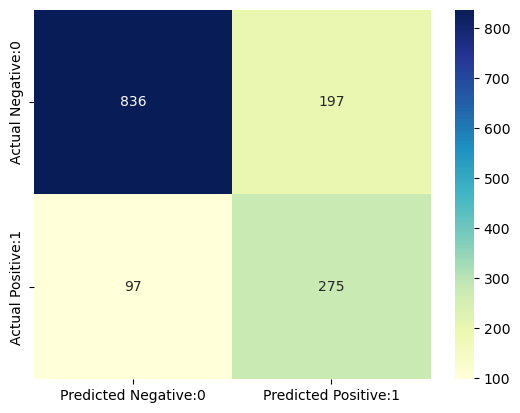

In [35]:
from sklearn.ensemble import RandomForestClassifier
classifier_name = 'Random Forest'

# max_depth:[10,15,20], min_samples_split:[6,8,10]
rfc = RandomForestClassifier(n_estimators=150, max_depth = 4,
                             min_samples_split=8, min_samples_leaf=2,
                             n_jobs=-1, random_state=0)

rfc.fit(X_train_st, y_train_st)

y_train_pred = rfc.predict(X_train_st)
y_test_pred = rfc.predict(Test_X_std)
y_test_prob = rfc.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

Random Forest: 

The best parameter values are:

Number of trees in the forest: 150
Minimum number of samples to split an internal node: 8
Minimum number of samples required to be at a leaf node: 2

Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.81      0.85      1033
         Yes       0.58      0.73      0.65       372

    accuracy                           0.79      1405
   macro avg       0.74      0.77      0.75      1405
weighted avg       0.81      0.79      0.80      1405


For training data: 
The accuracy of the model is 0.782 and its F1 score is 0.749.

For test data: 
The accuracy of the model is 0.789 and its F1 score is 0.648.

 [0.782 0.789 0.648 0.734 0.58  0.862 0.734]


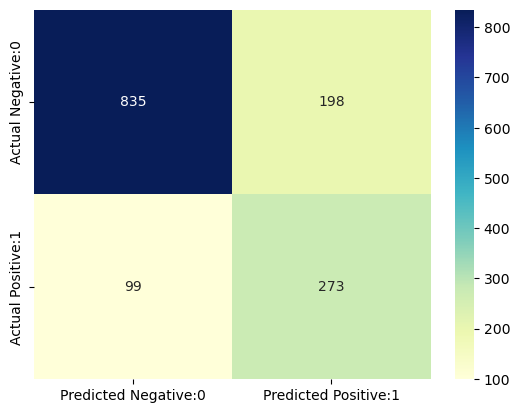

In [146]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=0)

# Define the parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [100, 150],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [2, 4, 6]
}

# Initialize GridSearchCV with the DecisionTreeRegressor, parameter grid, and neg_mean_squared_error as scoring
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best hyperparameters using cross-validation
grid_search.fit(X_train_st, y_train_st)

# Get the best k value and its corresponding mean squared error
best_params = grid_search.best_params_

classifier_name='Random Forest'

print("\033[1m"+classifier_name+": \033[0m")
print(f"\nThe best parameter values are:")
print(f"\nNumber of trees in the forest: {best_params['n_estimators']}")
print(f"Minimum number of samples to split an internal node: {best_params['min_samples_split']}")
print(f"Minimum number of samples required to be at a leaf node: {best_params['min_samples_leaf']}")
# print(f"Maximum depth of the tree: {best_params['max_depth']}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### AdaBoost Classifier


Classification Report: 
              precision    recall  f1-score   support

          No       0.90      0.80      0.85      1033
         Yes       0.58      0.74      0.65       372

    accuracy                           0.79      1405
   macro avg       0.74      0.77      0.75      1405
weighted avg       0.81      0.79      0.79      1405


For training data: 
The accuracy of the model is 0.781 and its F1 score is 0.752.

For test data: 
The accuracy of the model is 0.786 and its F1 score is 0.647.

 [0.781 0.786 0.647 0.739 0.575 0.86  0.739]


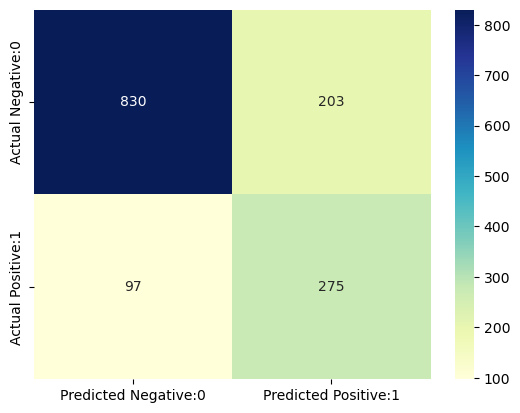

In [125]:
from sklearn.ensemble import AdaBoostClassifier
classifier_name='AdaBoost'

# learning_rate: [0.6,0.8,1.0]
adc = AdaBoostClassifier(n_estimators=150, learning_rate=0.8, random_state=0)

# Fit the model to find the best hyperparameters using cross-validation
adc.fit(X_train_st, y_train_st)

y_train_pred = adc.predict(X_train_st)
y_test_pred = adc.predict(Test_X_std)
y_test_prob = adc.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

AdaBoost: 

The best parameter values are:

Maximum number of estimators at which boosting is terminated: 150
Weight applied to each regressor at each boosting iteration: 1.0

Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.81      0.85      1033
         Yes       0.58      0.73      0.64       372

    accuracy                           0.79      1405
   macro avg       0.73      0.77      0.75      1405
weighted avg       0.81      0.79      0.79      1405


For training data: 
The accuracy of the model is 0.783 and its F1 score is 0.754.

For test data: 
The accuracy of the model is 0.786 and its F1 score is 0.644.

 [0.783 0.786 0.644 0.731 0.575 0.861 0.731]


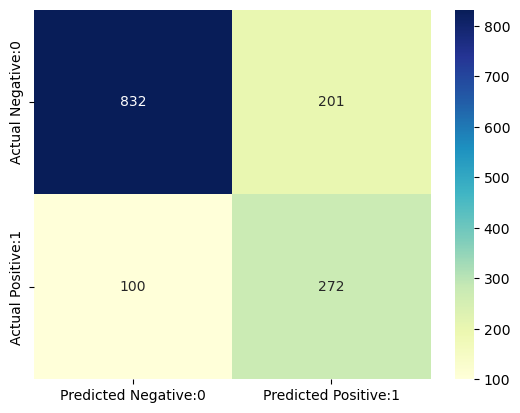

In [128]:
from sklearn.ensemble import AdaBoostClassifier
classifier_name='AdaBoost'

adc = AdaBoostClassifier(random_state=0)

# Define the parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 1.0]
}

# Initialize GridSearchCV with the DecisionTreeRegressor, parameter grid, and neg_mean_squared_error as scoring
grid_search = GridSearchCV(estimator=adc, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best hyperparameters using cross-validation
grid_search.fit(X_train_st, y_train_st)

# Get the best k value and its corresponding mean squared error
best_params = grid_search.best_params_

print("\033[1m"+classifier_name+": \033[0m")
print(f"\nThe best parameter values are:")
print(f"\nMaximum number of estimators at which boosting is terminated: {best_params['n_estimators']}")
print(f"Weight applied to each regressor at each boosting iteration: {best_params['learning_rate']}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### Gradient Boost Classifier


Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.80      0.84      1033
         Yes       0.57      0.74      0.64       372

    accuracy                           0.78      1405
   macro avg       0.73      0.77      0.74      1405
weighted avg       0.81      0.78      0.79      1405


For training data: 
The accuracy of the model is 0.779 and its F1 score is 0.748.

For test data: 
The accuracy of the model is 0.781 and its F1 score is 0.642.

 [0.779 0.781 0.642 0.739 0.567 0.863 0.739]


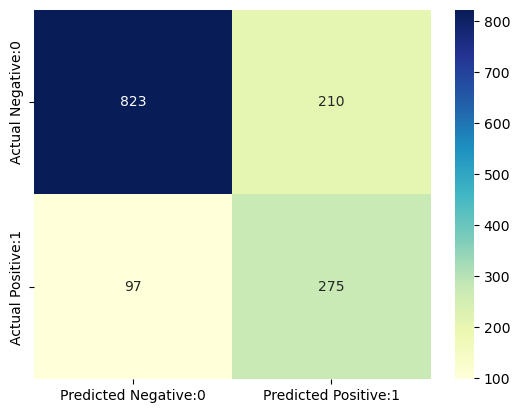

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_name='Gradient Boosting'

# learning_rate:[0.01, 0.05, 0.1], min_samples_split:[4, 5, 6]

gbc = GradientBoostingClassifier(n_estimators=150, learning_rate=0.01, min_samples_split=8,
                                 min_samples_leaf=4, random_state=0)

# Fit the model to find the best hyperparameters using cross-validation
gbc.fit(X_train_st, y_train_st)

y_train_pred = gbc.predict(X_train_st)
y_test_pred = gbc.predict(Test_X_std)
y_test_prob = gbc.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

Gradient Boosting: 

The best parameter values are:

Maximum number of estimators at which boosting is terminated: 150
Minimum number of samples to split an internal node: 6
Minimum number of samples required to be at a leaf node: 4

Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.81      0.85      1033
         Yes       0.58      0.72      0.64       372

    accuracy                           0.79      1405
   macro avg       0.73      0.77      0.75      1405
weighted avg       0.81      0.79      0.79      1405


For training data: 
The accuracy of the model is 0.784 and its F1 score is 0.749.

For test data: 
The accuracy of the model is 0.788 and its F1 score is 0.642.

 [0.784 0.788 0.642 0.718 0.58  0.859 0.718]


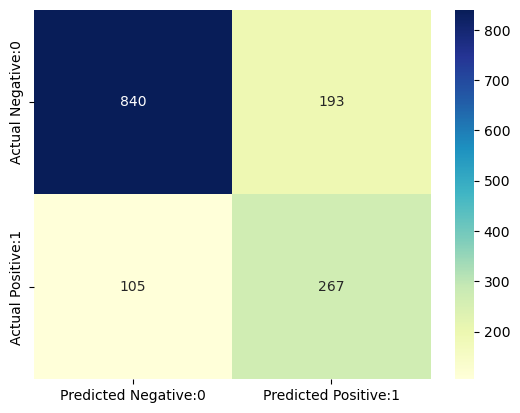

In [148]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_name='Gradient Boosting'

gbc = GradientBoostingClassifier(max_depth=4, learning_rate=0.01, random_state=0)

# 'learning_rate': [0.01, 0.05, 0.1]
# Define the parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [100, 150],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [2, 4]
}

# Initialize GridSearchCV with the DecisionTreeRegressor, parameter grid, and neg_mean_squared_error as scoring
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='f1', n_jobs=-1)

# Fit the model to find the best hyperparameters using cross-validation
grid_search.fit(X_train_st, y_train_st)

# Get the best k value and its corresponding mean squared error
best_params = grid_search.best_params_

print("\033[1m"+classifier_name+": \033[0m")
print(f"\nThe best parameter values are:")
print(f"\nMaximum number of estimators at which boosting is terminated: {best_params['n_estimators']}")
# print(f"Weight applied to each regressor at each boosting iteration: {best_params['learning_rate']}")
print(f"Minimum number of samples to split an internal node: {best_params['min_samples_split']}")
print(f"Minimum number of samples required to be at a leaf node: {best_params['min_samples_leaf']}")
# print(f"Maximum depth of the tree: {best_params['max_depth']}")

y_train_pred = grid_search.predict(X_train_st)
y_test_pred = grid_search.predict(Test_X_std)
y_test_prob = grid_search.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### XGBoost Classifier


Classification Report: 
              precision    recall  f1-score   support

          No       0.89      0.80      0.84      1033
         Yes       0.57      0.74      0.64       372

    accuracy                           0.78      1405
   macro avg       0.73      0.77      0.74      1405
weighted avg       0.81      0.78      0.79      1405


For training data: 
The accuracy of the model is 0.780 and its F1 score is 0.750.

For test data: 
The accuracy of the model is 0.781 and its F1 score is 0.641.

 [0.78  0.781 0.641 0.737 0.567 0.86  0.737]


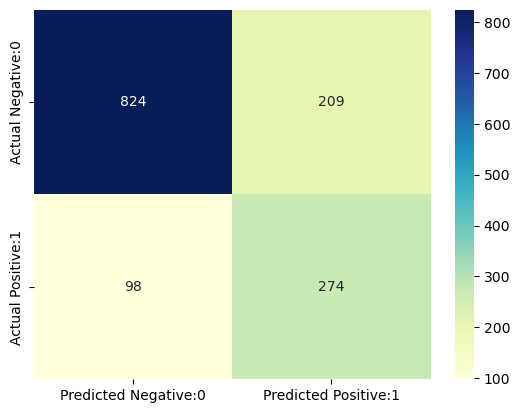

In [156]:
from xgboost import XGBClassifier
classifier_name='XGBoost'

# gamma: [0.1,0.2,0.3], learning_rate:[0.01, 0.05, 0.1], max_depth:[4, 5]

xgbc = XGBClassifier(n_estimators=150, learning_rate=0.01, max_depth=4,
                     gamma = 0.2, colsample_bytree=0.8, random_state=0) 

# Fit the model to find the best hyperparameters using cross-validation
xgbc.fit(X_train_st, y_train_st)

y_train_pred = xgbc.predict(X_train_st)
y_test_pred = xgbc.predict(Test_X_std)
y_test_prob = xgbc.predict_proba(Test_X_std)[:,1]

print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### ANN

Epoch 1/100
113/113 [==============================] - 2s 3ms/step - loss: 0.5850
Epoch 2/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4975
Epoch 3/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4890
Epoch 4/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4855
Epoch 5/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4832
Epoch 6/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4795
Epoch 7/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4793
Epoch 8/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4760
Epoch 9/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4755
Epoch 10/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4735
Epoch 11/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4721
Epoch 12/100
113/113 [==============================] - 0s 3ms/step - loss: 0.4705
Epoch 13/100


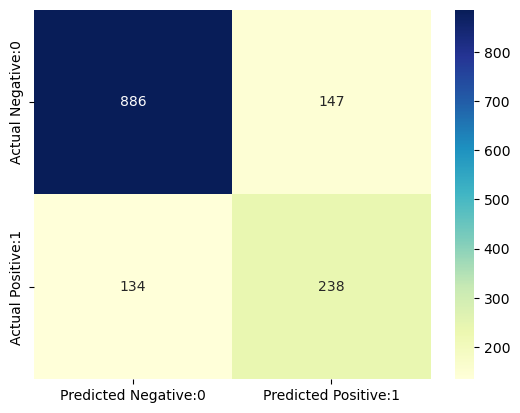

In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Set the random seeds for reproducibility
seed_value = 0
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

classifier_name='ANN'

# Create the neural network model
model=Sequential()

n_input=X_train_st.shape[1]    # No. of input features
hl = np.ceil(n_input/2)

# ANN Hyperparameters
num_neurons_list=(2*n_input, n_input)
batch_size=64
epochs=100
learning_rate=0.01
l2_reg=0.1  

# Input layer
model.add(InputLayer(input_shape=(n_input,)))

# Hidden layers
for num_neurons in num_neurons_list:
    model.add(Dense(num_neurons, activation='relu'))

# Output layer
model.add(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(l2_reg), activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

# Train the model on your training data
model.fit(X_train_st, y_train_st, epochs=epochs, batch_size=batch_size, verbose=1)

threshold=0.6
y_train_pred = model.predict(X_train_st)
y_train_pred = [0 if x < threshold else 1 for x in y_train_pred]

y_test_pred = model.predict(Test_X_std)
y_test_prob = y_test_pred

y_test_pred = [0 if x < threshold else 1 for x in y_test_pred]

# y_test_prob = model.predict(Test_X_std) # model.predict_proba(Test_X_std)[:,1]

print("\033[1m"+classifier_name+": \033[0m")
print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

### Naive Bayes

Naive Bayes: 

Classification Report: 
              precision    recall  f1-score   support

          No       0.91      0.71      0.79      1033
         Yes       0.50      0.80      0.61       372

    accuracy                           0.73      1405
   macro avg       0.70      0.75      0.70      1405
weighted avg       0.80      0.73      0.75      1405


For training data: 
The accuracy of the model is 0.749 and its F1 score is 0.742.

For test data: 
The accuracy of the model is 0.732 and its F1 score is 0.613.

 [0.749 0.732 0.613 0.801 0.496 0.84  0.801]


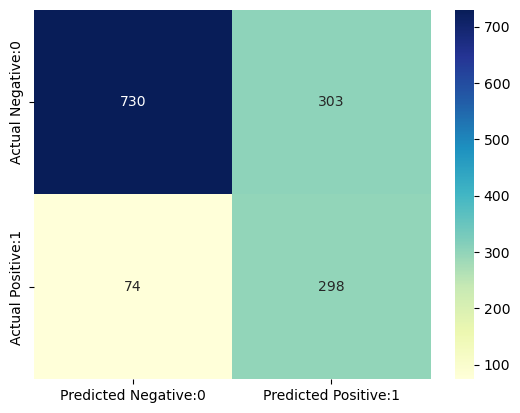

In [57]:
from sklearn.naive_bayes import GaussianNB
classifier_name='Naive Bayes'

nbc = GaussianNB()
nbc.fit(X_train_st, y_train_st)

y_train_pred = nbc.predict(X_train_st)
y_test_pred = nbc.predict(Test_X_std)
y_test_prob = nbc.predict_proba(Test_X_std)[:,1]

print("\033[1m"+classifier_name+": \033[0m")
print("\n\033[1mClassification Report: \033[0m")
eval_metric = classification_eval_metrics(Test_Y, y_test_pred, y_test_prob)

print("\n\033[1mFor training data: \033[0m")
classification_model_summary(y_train_st, y_train_pred)

print("\n\033[1mFor test data: \033[0m")
classification_model_summary(Test_Y, y_test_pred)

# plot_roc(Test_Y, y_test_prob, classifier_name)
roc_tuple = roc_auc_vals(Test_Y, y_test_prob)
roc_data[classifier_name] = roc_tuple

plot_cm(Test_Y, y_test_pred)

train_accuracy=accuracy_score(y_train_st, y_train_pred)
train_accuracy=round(train_accuracy, 3)

df_model_compare.loc[classifier_name]=[train_accuracy, eval_metric['Accuracy'], 
                                       eval_metric['F1-Score'], eval_metric['Recall'], 
                                       eval_metric['Precision'], eval_metric['ROC-AUC']] 
print("\n",df_model_compare.loc[classifier_name].values)

Naive Bayes Classifier performs poorer than the Dummy Classifier.

## 9. Model Evaluation

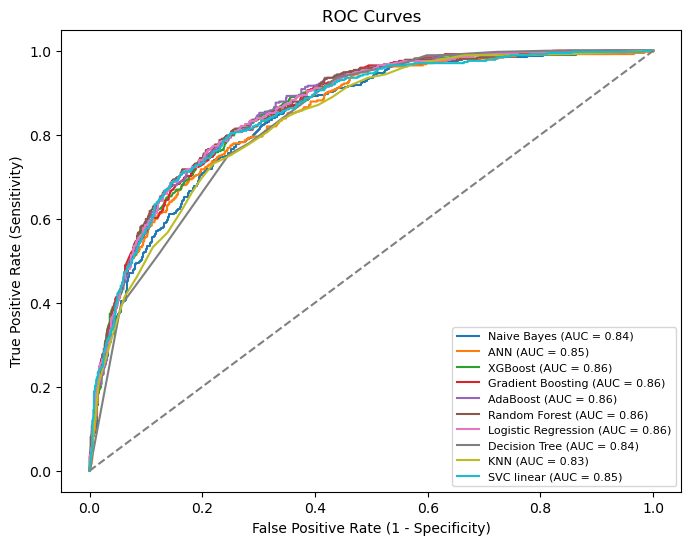

In [162]:
plot_all_roc(roc_data)

In [165]:
df_model_compare[metric_cols].sort_values(by=['F1-Score', 'Test Accuracy'], ascending = False) #list(df_model_compare.columns)

,Train Accuracy,Test Accuracy,F1-Score,Recall,Precision,ROC-AUC
Random Forest,0.782,0.789,0.648,0.734,0.580,0.862
Logistic Regression,0.767,0.784,0.645,0.742,0.570,0.860
AdaBoost,0.783,0.786,0.644,0.731,0.575,0.861
Gradient Boosting,0.784,0.788,0.642,0.718,0.580,0.859
XGBoost,0.780,0.781,0.641,0.737,0.567,0.860
SVC linear,0.763,0.768,0.640,0.780,0.543,0.855
ANN,0.789,0.800,0.629,0.640,0.618,0.845
KNN,0.777,0.767,0.625,0.731,0.545,0.834
Decision Tree,0.759,0.753,0.617,0.753,0.523,0.835
Naive Bayes,0.749,0.732,0.613,0.801,0.496,0.840


**Inference:**

- The Random Forest Classifier showed the best performance among all the models. It achieved the highest F1 score and AUC. Additionally, its accuracy on the test data is higher than that of the dummy classifier (73.5%).

- The Logistic Regression model displayed a comparable performance, with only a slightly lower F1 score, accuracy, and AUC.

- The performance of models like AdaBoost, Gradient Boosting, XGBoost, and SVC (with a linear kernel) is quite similar, showing only slight differences in terms of F1 score and test accuracy.

- The ANN model exhibited the highest test accuracy; however, its F1 score was lower compared to the aforementioned models. Moreover, it demonstrated a lower AUC.

- Both the KNN and Decision Tree models achieved a high recall rate. However, their F1 scores and accuracy were relatively low.

- The Naive Bayes model presented the weakest performance, with an accuracy slightly lower than that of the dummy classifier. Nonetheless, it showed a high recall rate.

Out of all the models we tested, the **Random Forest Classifier** model showed the best performance. It achieved an F1 score of 0.65, a test accuracy of 79%, and an AUC of 0.862.

## 10. Model Saving:

In [6]:
model_filename = 'model.pkl'
pickle.dump(rfc, open(model_filename,'wb'))

In [19]:
import pickle

model_filename = 'model.pkl'
load_model = pickle.load(open(model_filename, 'rb'))

ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

In [ ]:
load_model = pickle.load(open(model_filename, 'rb'))

In [37]:
dd = {'tenure':1, 'MonthlyCharges':14.1, 'SeniorCitizen': 'No', 'Partner': 'No', 
      'Dependents': 'No', 'OnlineSecurity': 'No', 'TechSupport': 'No', 'PaperlessBilling': 'Yes', 
      'Contract': 'Six months', 'PaymentMethod': 'Other'}

In [38]:
data=transform_features(dd) # Function to transform the user's input 

In [39]:
data

{'tenure': 0.013888888888888888,
 'MonthlyCharges': -0.04129353233830846,
 'SeniorCitizen_1': 0,
 'Partner_Yes': 0,
 'Dependents_Yes': 0,
 'OnlineSecurity_Yes': 0,
 'TechSupport_Yes': 0,
 'Contract_One year': 0,
 'Contract_Two year': 0,
 'PaperlessBilling_Yes': 1,
 'PaymentMethod_Credit card (automatic)': 0,
 'PaymentMethod_Electronic check': 0}

In [40]:
df1=pd.DataFrame(data, index=[0])
single = load_model.predict(df1)
probability = load_model.predict_proba(df1)[:,1]
print(single, probability)

[1] [0.53776176]


In [13]:
if single == 1:
    print("This Customer is likely to be Churned!")
    print(f"Confidence level is {np.round(probability*100, 2)}")
else:
    print("This Customer is likely to be Continue!")
    print(f"Confidence level is {np.round(probability*100, 2)}")

This Customer is likely to be Continue!
Confidence level is [36.28]
